In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import numpy as np
from matplotlib.colors import LogNorm
import os

import sys
sys.path.append("../from_EC/modified_from_EC")
%aimport kinetics_analysis

NameError: name 'sys' is not defined

# Activity thresholding: UMIs @ time points
From Max: 
> In the Treble data. Can you quantify how many sequences are active in each time point? Can you infer the first time point an ad is active and use that as a proxy for speed?

> make a histogram at each time point and maybe use mean + 2SD?

From Marissa:
> If there's good correlation between the sortseq and TREBL data, we can use the 20% active threshold from the Gcn4 preprint, but at some point I'd like to try Aaron's machine noise threshold! Difference between time points sounds like another good way to do it though! You can also potentially compare up Emily's negative controls, but those are very low activity (possibly slightly repressive) I think, so might be too lenient of a threshold

Approach:
1. Histograms at each time point
2. Sort seq regression
3. Distribution shape

# 1. Preparing filtered data

In [332]:
# All activities from EC's demultixed UMI calcuations
concatenated_df = pd.read_csv("../from_EC/20250226_TREBL_MAZ06/demultiplexed_counts.csv")
concatenated_df["Time"] = concatenated_df["Library"].str.split("_").str[1]
concatenated_df["sample"] = concatenated_df["Library"].str.split("_").str[0]
concatenated_df = concatenated_df.rename(columns={"Ratio_negctrlnorm": "Ratio_negCTRLnorm",
    "UMIs_RPTR": "RPTR_UMIs",
    "UMIs_AD": "AD_UMIs"})
concatenated_df

,Barcode_RPTR,RPTR_UMIs,Reads_RPTR,RPTR_BC,AD,AD_BC,AD_ADBC,Barcode_AD,Tile,AD_UMIs,Reads_AD,Ratio,Ratio_negCTRLnorm,Library,Time,sample
0,TATACATCCACCAT,402,25490.0,TATACATCCACCAT,GGTACTATTTCTCCTAAAGATTTGATGATGGATGCTTCTGTTCCAC...,ACTCGGAATTG,GGTACTATTTCTCCTAAAGATTTGATGATGGATGCTTCTGTTCCAC...,ACTCGGAATTG,GGTACTATTTCTCCTAAAGATTTGATGATGGATGCTTCTGTTCCAC...,646,7557.0,0.622291,5.651387,3_5,5,3
1,AAGTGGTGAGAAGC,2784,167960.0,AAGTGGTGAGAAGC,GATGCTTCTCCATTCTTGAATGAATCATTTGAAACTTCTCCAATGT...,CATCTAGGAAA,GATGCTTCTCCATTCTTGAATGAATCATTTGAAACTTCTCCAATGT...,CATCTAGGAAA,GATGCTTCTCCATTCTTGAATGAATCATTTGAAACTTCTCCAATGT...,806,9306.0,3.454094,31.368640,3_5,5,3
2,GTACGAAGTCAGTG,1349,79520.0,GTACGAAGTCAGTG,TCATTTGAAACTTCTCCAATGTTTCAAGGTGAACCAATGTTAAATT...,TGGGAGCCCTT,TCATTTGAAACTTCTCCAATGTTTCAAGGTGAACCAATGTTAAATT...,TGGGAGCCCTT,TCATTTGAAACTTCTCCAATGTTTCAAGGTGAACCAATGTTAAATT...,657,7982.0,2.053272,18.646962,3_5,5,3
3,CTATTCCGAAATAT,1012,66011.0,CTATTCCGAAATAT,ATGTTTACTGATTTGGATGTTGCTGGTCATGAAGATTGGCCATCTT...,AAGTTCTTTCA,ATGTTTACTGATTTGGATGTTGCTGGTCATGAAGATTGGCCATCTT...,AAGTTCTTTCA,ATGTTTACTGATTTGGATGTTGCTGGTCATGAAGATTGGCCATCTT...,167,2170.0,6.059880,55.033299,3_5,5,3
4,AAAGTTCTCAGACA,690,41207.0,AAAGTTCTCAGACA,TTGGATTTGGATGACTTTACTGGATTTGAAGGTGGTGCTTCTACTA...,TCTTAGGCTCG,TTGGATTTGGATGACTTTACTGGATTTGAAGGTGGTGCTTCTACTA...,TCTTAGGCTCG,TTGGATTTGGATGACTTTACTGGATTTGAAGGTGGTGCTTCTACTA...,917,11109.0,0.752454,6.833470,3_5,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347306,TTCAGAGAAAGCGC,13,254.0,TTCAGAGAAAGCGC,AATTTGTGGATGGGTTTGCATGGTCCTAAAGATCAAGAAGCTAGAG...,CGGGGTGTCTG,AATTTGTGGATGGGTTTGCATGGTCCTAAAGATCAAGAAGCTAGAG...,CGGGGTGTCTG,AATTTGTGGATGGGTTTGCATGGTCCTAAAGATCAAGAAGCTAGAG...,57,416.0,0.228070,0.575070,1_240,240,1
347307,AAATCAGGTGCGCT,3,84.0,AAATCAGGTGCGCT,AGACATTCTTCTAATATTCCATCTGCTTCTTCTTTGCAGAATCAAA...,GAAAACTTTAA,AGACATTCTTCTAATATTCCATCTGCTTCTTCTTTGCAGAATCAAA...,GAAAACTTTAA,AGACATTCTTCTAATATTCCATCTGCTTCTTCTTTGCAGAATCAAA...,53,414.0,0.056604,0.142724,1_240,240,1
347308,AATAAATTGTTATG,1,32.0,AATAAATTGTTATG,TGTTCATTTAGATCTATTGAAAGAAATCAATTTAGAAGATCTTCTG...,CGCCAGGCGCT,TGTTCATTTAGATCTATTGAAAGAAATCAATTTAGAAGATCTTCTG...,CGCCAGGCGCT,TGTTCATTTAGATCTATTGAAAGAAATCAATTTAGAAGATCTTCTG...,313,2896.0,0.003195,0.008056,1_240,240,1
347309,ATAAAACTAGCCTG,1,22.0,ATAAAACTAGCCTG,TCTTTGTCTTTGGGTAAAGGTTGTGCTGGTGAATTGACTCCACCAC...,GCATGAGTTAG,TCTTTGTCTTTGGGTAAAGGTTGTGCTGGTGAATTGACTCCACCAC...,GCATGAGTTAG,TCTTTGTCTTTGGGTAAAGGTTGTGCTGGTGAATTGACTCCACCAC...,536,4436.0,0.001866,0.004704,1_240,240,1


In [333]:
# Only keep tiles which at least in at least two time points and samples
tile_time_sample_counts = concatenated_df.groupby('Tile')['sample'].nunique()
valid_tiles = tile_time_sample_counts[tile_time_sample_counts>1].index
filtered_cat_1 = concatenated_df[concatenated_df['Tile'].isin(valid_tiles)]
filtered_cat_1

,Barcode_RPTR,RPTR_UMIs,Reads_RPTR,RPTR_BC,AD,AD_BC,AD_ADBC,Barcode_AD,Tile,AD_UMIs,Reads_AD,Ratio,Ratio_negCTRLnorm,Library,Time,sample
0,TATACATCCACCAT,402,25490.0,TATACATCCACCAT,GGTACTATTTCTCCTAAAGATTTGATGATGGATGCTTCTGTTCCAC...,ACTCGGAATTG,GGTACTATTTCTCCTAAAGATTTGATGATGGATGCTTCTGTTCCAC...,ACTCGGAATTG,GGTACTATTTCTCCTAAAGATTTGATGATGGATGCTTCTGTTCCAC...,646,7557.0,0.622291,5.651387,3_5,5,3
1,AAGTGGTGAGAAGC,2784,167960.0,AAGTGGTGAGAAGC,GATGCTTCTCCATTCTTGAATGAATCATTTGAAACTTCTCCAATGT...,CATCTAGGAAA,GATGCTTCTCCATTCTTGAATGAATCATTTGAAACTTCTCCAATGT...,CATCTAGGAAA,GATGCTTCTCCATTCTTGAATGAATCATTTGAAACTTCTCCAATGT...,806,9306.0,3.454094,31.368640,3_5,5,3
2,GTACGAAGTCAGTG,1349,79520.0,GTACGAAGTCAGTG,TCATTTGAAACTTCTCCAATGTTTCAAGGTGAACCAATGTTAAATT...,TGGGAGCCCTT,TCATTTGAAACTTCTCCAATGTTTCAAGGTGAACCAATGTTAAATT...,TGGGAGCCCTT,TCATTTGAAACTTCTCCAATGTTTCAAGGTGAACCAATGTTAAATT...,657,7982.0,2.053272,18.646962,3_5,5,3
3,CTATTCCGAAATAT,1012,66011.0,CTATTCCGAAATAT,ATGTTTACTGATTTGGATGTTGCTGGTCATGAAGATTGGCCATCTT...,AAGTTCTTTCA,ATGTTTACTGATTTGGATGTTGCTGGTCATGAAGATTGGCCATCTT...,AAGTTCTTTCA,ATGTTTACTGATTTGGATGTTGCTGGTCATGAAGATTGGCCATCTT...,167,2170.0,6.059880,55.033299,3_5,5,3
4,AAAGTTCTCAGACA,690,41207.0,AAAGTTCTCAGACA,TTGGATTTGGATGACTTTACTGGATTTGAAGGTGGTGCTTCTACTA...,TCTTAGGCTCG,TTGGATTTGGATGACTTTACTGGATTTGAAGGTGGTGCTTCTACTA...,TCTTAGGCTCG,TTGGATTTGGATGACTTTACTGGATTTGAAGGTGGTGCTTCTACTA...,917,11109.0,0.752454,6.833470,3_5,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347306,TTCAGAGAAAGCGC,13,254.0,TTCAGAGAAAGCGC,AATTTGTGGATGGGTTTGCATGGTCCTAAAGATCAAGAAGCTAGAG...,CGGGGTGTCTG,AATTTGTGGATGGGTTTGCATGGTCCTAAAGATCAAGAAGCTAGAG...,CGGGGTGTCTG,AATTTGTGGATGGGTTTGCATGGTCCTAAAGATCAAGAAGCTAGAG...,57,416.0,0.228070,0.575070,1_240,240,1
347307,AAATCAGGTGCGCT,3,84.0,AAATCAGGTGCGCT,AGACATTCTTCTAATATTCCATCTGCTTCTTCTTTGCAGAATCAAA...,GAAAACTTTAA,AGACATTCTTCTAATATTCCATCTGCTTCTTCTTTGCAGAATCAAA...,GAAAACTTTAA,AGACATTCTTCTAATATTCCATCTGCTTCTTCTTTGCAGAATCAAA...,53,414.0,0.056604,0.142724,1_240,240,1
347308,AATAAATTGTTATG,1,32.0,AATAAATTGTTATG,TGTTCATTTAGATCTATTGAAAGAAATCAATTTAGAAGATCTTCTG...,CGCCAGGCGCT,TGTTCATTTAGATCTATTGAAAGAAATCAATTTAGAAGATCTTCTG...,CGCCAGGCGCT,TGTTCATTTAGATCTATTGAAAGAAATCAATTTAGAAGATCTTCTG...,313,2896.0,0.003195,0.008056,1_240,240,1
347309,ATAAAACTAGCCTG,1,22.0,ATAAAACTAGCCTG,TCTTTGTCTTTGGGTAAAGGTTGTGCTGGTGAATTGACTCCACCAC...,GCATGAGTTAG,TCTTTGTCTTTGGGTAAAGGTTGTGCTGGTGAATTGACTCCACCAC...,GCATGAGTTAG,TCTTTGTCTTTGGGTAAAGGTTGTGCTGGTGAATTGACTCCACCAC...,536,4436.0,0.001866,0.004704,1_240,240,1


In [334]:
# Remove outliers within each sample
filtered_cat_2 = kinetics_analysis.remove_outliers_faster(filtered_cat_1, ['sample', 'Tile', 'Time'], 'Ratio_negCTRLnorm')
filtered_cat_2

,Barcode_RPTR,RPTR_UMIs,Reads_RPTR,RPTR_BC,AD,AD_BC,AD_ADBC,Barcode_AD,Tile,AD_UMIs,Reads_AD,Ratio,Ratio_negCTRLnorm,Library,Time,sample
0,TATACATCCACCAT,402,25490.0,TATACATCCACCAT,GGTACTATTTCTCCTAAAGATTTGATGATGGATGCTTCTGTTCCAC...,ACTCGGAATTG,GGTACTATTTCTCCTAAAGATTTGATGATGGATGCTTCTGTTCCAC...,ACTCGGAATTG,GGTACTATTTCTCCTAAAGATTTGATGATGGATGCTTCTGTTCCAC...,646,7557.0,0.622291,5.651387,3_5,5,3
1,AAGTGGTGAGAAGC,2784,167960.0,AAGTGGTGAGAAGC,GATGCTTCTCCATTCTTGAATGAATCATTTGAAACTTCTCCAATGT...,CATCTAGGAAA,GATGCTTCTCCATTCTTGAATGAATCATTTGAAACTTCTCCAATGT...,CATCTAGGAAA,GATGCTTCTCCATTCTTGAATGAATCATTTGAAACTTCTCCAATGT...,806,9306.0,3.454094,31.368640,3_5,5,3
2,GTACGAAGTCAGTG,1349,79520.0,GTACGAAGTCAGTG,TCATTTGAAACTTCTCCAATGTTTCAAGGTGAACCAATGTTAAATT...,TGGGAGCCCTT,TCATTTGAAACTTCTCCAATGTTTCAAGGTGAACCAATGTTAAATT...,TGGGAGCCCTT,TCATTTGAAACTTCTCCAATGTTTCAAGGTGAACCAATGTTAAATT...,657,7982.0,2.053272,18.646962,3_5,5,3
3,CTATTCCGAAATAT,1012,66011.0,CTATTCCGAAATAT,ATGTTTACTGATTTGGATGTTGCTGGTCATGAAGATTGGCCATCTT...,AAGTTCTTTCA,ATGTTTACTGATTTGGATGTTGCTGGTCATGAAGATTGGCCATCTT...,AAGTTCTTTCA,ATGTTTACTGATTTGGATGTTGCTGGTCATGAAGATTGGCCATCTT...,167,2170.0,6.059880,55.033299,3_5,5,3
4,AAAGTTCTCAGACA,690,41207.0,AAAGTTCTCAGACA,TTGGATTTGGATGACTTTACTGGATTTGAAGGTGGTGCTTCTACTA...,TCTTAGGCTCG,TTGGATTTGGATGACTTTACTGGATTTGAAGGTGGTGCTTCTACTA...,TCTTAGGCTCG,TTGGATTTGGATGACTTTACTGGATTTGAAGGTGGTGCTTCTACTA...,917,11109.0,0.752454,6.833470,3_5,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347119,TTCAGAGAAAGCGC,13,254.0,TTCAGAGAAAGCGC,AATTTGTGGATGGGTTTGCATGGTCCTAAAGATCAAGAAGCTAGAG...,CGGGGTGTCTG,AATTTGTGGATGGGTTTGCATGGTCCTAAAGATCAAGAAGCTAGAG...,CGGGGTGTCTG,AATTTGTGGATGGGTTTGCATGGTCCTAAAGATCAAGAAGCTAGAG...,57,416.0,0.228070,0.575070,1_240,240,1
347120,AAATCAGGTGCGCT,3,84.0,AAATCAGGTGCGCT,AGACATTCTTCTAATATTCCATCTGCTTCTTCTTTGCAGAATCAAA...,GAAAACTTTAA,AGACATTCTTCTAATATTCCATCTGCTTCTTCTTTGCAGAATCAAA...,GAAAACTTTAA,AGACATTCTTCTAATATTCCATCTGCTTCTTCTTTGCAGAATCAAA...,53,414.0,0.056604,0.142724,1_240,240,1
347121,AATAAATTGTTATG,1,32.0,AATAAATTGTTATG,TGTTCATTTAGATCTATTGAAAGAAATCAATTTAGAAGATCTTCTG...,CGCCAGGCGCT,TGTTCATTTAGATCTATTGAAAGAAATCAATTTAGAAGATCTTCTG...,CGCCAGGCGCT,TGTTCATTTAGATCTATTGAAAGAAATCAATTTAGAAGATCTTCTG...,313,2896.0,0.003195,0.008056,1_240,240,1
347122,ATAAAACTAGCCTG,1,22.0,ATAAAACTAGCCTG,TCTTTGTCTTTGGGTAAAGGTTGTGCTGGTGAATTGACTCCACCAC...,GCATGAGTTAG,TCTTTGTCTTTGGGTAAAGGTTGTGCTGGTGAATTGACTCCACCAC...,GCATGAGTTAG,TCTTTGTCTTTGGGTAAAGGTTGTGCTGGTGAATTGACTCCACCAC...,536,4436.0,0.001866,0.004704,1_240,240,1


In [335]:
# Compute sample-level means -- across all BCs
sample_means_cat = filtered_cat_2.groupby(['Tile', 'Time', 'sample'])['Ratio_negCTRLnorm'].mean().reset_index()
sample_means_cat

,Tile,Time,sample,Ratio_negCTRLnorm
0,AAACAAAGAGCTACTCCATTGACTCCAGTTGTTCCAGAATCTGATG...,0,1,1.582093
1,AAACAAAGAGCTACTCCATTGACTCCAGTTGTTCCAGAATCTGATG...,0,2,0.921957
2,AAACAAAGAGCTACTCCATTGACTCCAGTTGTTCCAGAATCTGATG...,0,3,1.258584
3,AAACAAAGAGCTACTCCATTGACTCCAGTTGTTCCAGAATCTGATG...,10,1,1.289787
4,AAACAAAGAGCTACTCCATTGACTCCAGTTGTTCCAGAATCTGATG...,10,2,1.002675
...,...,...,...,...
230937,TTTGTTTCTGGTACTGTTTCTCCTAAAGATTTGCATGTTGATACTG...,30,2,7.493609
230938,TTTGTTTCTGGTACTGTTTCTCCTAAAGATTTGCATGTTGATACTG...,30,3,8.934322
230939,TTTGTTTCTGGTACTGTTTCTCCTAAAGATTTGCATGTTGATACTG...,5,1,7.713425
230940,TTTGTTTCTGGTACTGTTTCTCCTAAAGATTTGCATGTTGATACTG...,5,2,4.285752


In [336]:
# Compute standard deviation across 3 sample means
std_devs_cat = sample_means_cat.groupby(['Tile', 'Time'])['Ratio_negCTRLnorm'].std().unstack(level='Time')
std_devs_cat

Time,0,10,15,180,240,30,5
Tile,,,,,,,
AAACAAAGAGCTACTCCATTGACTCCAGTTGTTCCAGAATCTGATGATCCAGTTGCTTTGAAGAGAGCTAGAAATACTGAAGCTGCTAGAAGATCTAGAGCTAGGAAATTGGAAAGAATG,0.330090,0.203824,0.496080,0.055946,0.522002,0.858328,0.551313
AAACAAAGATCTCAACCATTGCAACCAATTATTATTGATGATATTAAAGATGCTGCTGCTTTGAAGAGAGCTAAGAATACTGAAGCTGCTAGAAGATCTAGAGCTAGGAAGATGGAAAGA,0.110441,0.499625,0.412843,0.584507,0.174427,0.008280,0.705516
AAACAAATGTATATTGGTTCTAATAAACCATTGGGTAAAGATCATAGAGGTTATAATGCTCATAATTGGAAACAATGTGCTATTTACTTTCATATTAGATATCCAAATGTTTCTAATTGT,0.292430,0.010140,0.320101,0.155198,0.122804,0.233617,0.750194
AAACAACCAGATGTTGCTACTTGGGATGCTCATTCTAATAAAGGTCAATGTTTGTTAAATTCTGGTGGTTCTGCTAGACCATTGATTATTTGGTTGCCACATTCTCACTTTAAAGAATAT,2.039598,0.728617,0.746311,0.135646,0.879244,1.948277,0.392088
AAACAAGATAAAGATGATGTTACTTCTGAAGTTGCTGATAGAAGATGTAAATCTACTTCTGATTCTCAAGATGTTTATGATAAACCAGGTGAATCTGAATCTCCAGAAAGAACTGAATAT,0.147264,0.758131,0.256276,0.210639,0.221155,0.650056,0.529351
...,...,...,...,...,...,...,...
TTTGTTGATGGTTTGGATGCTGCTTCTTTGGCTATGTTTGATACTCAACAATTGGATAAAGTTCAAGCATTTGTTTCTGGTACTGTTTCTCCTAAAGATTTGCATGTTGATACTGCTCCA,0.142995,1.343837,2.561246,2.592146,1.845654,5.801335,1.908044
TTTGTTGCTTCTCCAACATTTAATCATAAATTCTCTTCTTCTAATGCATTTACTACTGAACAAATGAAGACATTTGATCCAGAAGCTGCATTTAATGAATTGTTCTCTCCAGAGTTCTCT,0.790555,3.100196,2.623520,7.610656,3.936901,14.265229,10.191587
TTTGTTGGTGATGGTGATTTGGATCAATCTTTGGCTGCTGATCCATGGTATCCATTGTTTCCAGAATCTGATAAATTGGATCAACCAACTAAAGTTGAACAATCTCCATTGATTATTGAT,0.522777,1.168326,1.759513,4.446913,2.970720,8.604516,1.460482


In [337]:
# Compute the mean across BCs and samples (not just raw mean)
final_means_cat = sample_means_cat.groupby(['Tile', 'Time'])['Ratio_negCTRLnorm'].mean().unstack(level='Time')
final_means_cat

Time,0,10,15,180,240,30,5
Tile,,,,,,,
AAACAAAGAGCTACTCCATTGACTCCAGTTGTTCCAGAATCTGATGATCCAGTTGCTTTGAAGAGAGCTAGAAATACTGAAGCTGCTAGAAGATCTAGAGCTAGGAAATTGGAAAGAATG,1.254211,1.062693,1.532920,1.240728,1.206545,1.787659,1.351119
AAACAAAGATCTCAACCATTGCAACCAATTATTATTGATGATATTAAAGATGCTGCTGCTTTGAAGAGAGCTAAGAATACTGAAGCTGCTAGAAGATCTAGAGCTAGGAAGATGGAAAGA,1.265805,1.819540,1.700459,2.317024,2.080985,1.885667,2.077828
AAACAAATGTATATTGGTTCTAATAAACCATTGGGTAAAGATCATAGAGGTTATAATGCTCATAATTGGAAACAATGTGCTATTTACTTTCATATTAGATATCCAAATGTTTCTAATTGT,1.166629,1.000460,0.730895,0.709995,0.732983,0.797948,1.621634
AAACAACCAGATGTTGCTACTTGGGATGCTCATTCTAATAAAGGTCAATGTTTGTTAAATTCTGGTGGTTCTGCTAGACCATTGATTATTTGGTTGCCACATTCTCACTTTAAAGAATAT,1.984682,1.299895,1.467031,1.668606,1.693269,1.947597,0.934068
AAACAAGATAAAGATGATGTTACTTCTGAAGTTGCTGATAGAAGATGTAAATCTACTTCTGATTCTCAAGATGTTTATGATAAACCAGGTGAATCTGAATCTCCAGAAAGAACTGAATAT,0.679833,1.127691,1.071415,1.504457,1.322705,1.427080,0.959878
...,...,...,...,...,...,...,...
TTTGTTGATGGTTTGGATGCTGCTTCTTTGGCTATGTTTGATACTCAACAATTGGATAAAGTTCAAGCATTTGTTTCTGGTACTGTTTCTCCTAAAGATTTGCATGTTGATACTGCTCCA,1.124169,18.108378,25.314241,15.885584,11.023455,38.055564,10.208349
TTTGTTGCTTCTCCAACATTTAATCATAAATTCTCTTCTTCTAATGCATTTACTACTGAACAAATGAAGACATTTGATCCAGAAGCTGCATTTAATGAATTGTTCTCTCCAGAGTTCTCT,1.676623,30.615512,26.635877,24.434864,17.924639,73.708402,16.050106
TTTGTTGGTGATGGTGATTTGGATCAATCTTTGGCTGCTGATCCATGGTATCCATTGTTTCCAGAATCTGATAAATTGGATCAACCAACTAAAGTTGAACAATCTCCATTGATTATTGAT,1.981525,14.324264,20.019784,19.689651,12.861237,42.340589,6.746955


In [338]:
# Difference between score at t=0 and Vmax must be at least 5: means active
filtered_final_means_cat = kinetics_analysis.filter_by_maximum_threshold(final_means_cat).dropna()
filtered_final_means_cat["Activity"] = "active"
filtered_final_means_cat

Time,0,10,15,180,240,30,5,Activity
Tile,,,,,,,,
AAACAAGGTAATAAGATGTTCTCTGGTAATTATACTTCTTATCATTTGCCACCACCAAATATGAGATTGCAACCACATGCTGAATTGGATTTGTTGGACTTTGCTACATTTGATGGTGGT,0.729149,5.794430,6.832395,7.872477,4.974632,12.941360,2.400326,active
AAACAATTGCAAACTAATTCTAATATGTCTGATGATACATTTGCTGGTTTGCCATCTGGTACTGTTTCTCCAACTGATTTGATGTTGGATGCTTCTGCTCCATCTTCTGCTACATTTACT,2.521581,21.738648,29.841027,17.966665,13.429892,54.876878,12.081788,active
AAACAATTTCAGAATTATCAAAGAAGAAGATTGATGTCTCAATCTAATTTGATTCAAGGTTTGGAAATGTCTGACTTCTTTAATGATATTCCATCTCATCCATTTGGTAATGACTTTGAT,1.957038,6.178987,9.341038,11.904372,9.808035,15.666855,4.141078,active
AAACATGCTGATATGGATTTGTTTGATGAATTTACTGCATTTGAAGGTGGTGCTTCTACTACTCAGAATGCATTTCCATCTGCTTATTCTTCTCCAGCTGTTCCAACTATTTATGATCCA,0.735624,8.889710,11.602415,12.913788,8.601112,29.655114,5.256059,active
AAACCAGAAATTATTGGTGAATTGTCTTGTCATTTGCCAACTGCTGGTGCTCATGTTACTGGTGAACCAGATCATTCTCCAATTTCTGTTCATACTGATGTCTTGGATTCTGTCTTCTCT,1.254759,5.638187,6.199079,8.506463,6.853283,6.350312,3.328503,active
...,...,...,...,...,...,...,...,...
TTTGTTAAATCTTTGAAAGGTAGGAAACCATTGACTGGTGTTGCTTTGGGTATTTATTCTTATGAAGTTAGATCTAAGACTGATAATTCTTTGAATTTGAGAATCTTGACTTTGCATACT,1.070978,8.822356,5.450700,11.479959,9.325870,35.162836,3.340094,active
TTTGTTGATGGTTTGGATGCTGCTTCTTTGGCTATGTTTGATACTCAACAATTGGATAAAGTTCAAGCATTTGTTTCTGGTACTGTTTCTCCTAAAGATTTGCATGTTGATACTGCTCCA,1.124169,18.108378,25.314241,15.885584,11.023455,38.055564,10.208349,active
TTTGTTGCTTCTCCAACATTTAATCATAAATTCTCTTCTTCTAATGCATTTACTACTGAACAAATGAAGACATTTGATCCAGAAGCTGCATTTAATGAATTGTTCTCTCCAGAGTTCTCT,1.676623,30.615512,26.635877,24.434864,17.924639,73.708402,16.050106,active


In [339]:
final_means_cat['Vmax'] = final_means_cat[["0", "10", "15", "180", "240", "30", "5"]].max(axis=1)
final_means_cat['Avg_StdDev'] = std_devs_cat.loc[final_means_cat.index].mean(axis=1)
final_means_cat = pd.merge(final_means_cat.reset_index(), filtered_final_means_cat.reset_index(), how = 'left').set_index("Tile")
final_means_cat["Activity"] = final_means_cat["Activity"].fillna("inactive")
final_means_cat

Time,0,10,15,180,240,30,5,Vmax,Avg_StdDev,Activity
Tile,,,,,,,,,,
AAACAAAGAGCTACTCCATTGACTCCAGTTGTTCCAGAATCTGATGATCCAGTTGCTTTGAAGAGAGCTAGAAATACTGAAGCTGCTAGAAGATCTAGAGCTAGGAAATTGGAAAGAATG,1.254211,1.062693,1.532920,1.240728,1.206545,1.787659,1.351119,1.787659,0.431083,inactive
AAACAAAGATCTCAACCATTGCAACCAATTATTATTGATGATATTAAAGATGCTGCTGCTTTGAAGAGAGCTAAGAATACTGAAGCTGCTAGAAGATCTAGAGCTAGGAAGATGGAAAGA,1.265805,1.819540,1.700459,2.317024,2.080985,1.885667,2.077828,2.317024,0.356520,inactive
AAACAAATGTATATTGGTTCTAATAAACCATTGGGTAAAGATCATAGAGGTTATAATGCTCATAATTGGAAACAATGTGCTATTTACTTTCATATTAGATATCCAAATGTTTCTAATTGT,1.166629,1.000460,0.730895,0.709995,0.732983,0.797948,1.621634,1.621634,0.269212,inactive
AAACAACCAGATGTTGCTACTTGGGATGCTCATTCTAATAAAGGTCAATGTTTGTTAAATTCTGGTGGTTCTGCTAGACCATTGATTATTTGGTTGCCACATTCTCACTTTAAAGAATAT,1.984682,1.299895,1.467031,1.668606,1.693269,1.947597,0.934068,1.984682,0.981397,inactive
AAACAAGATAAAGATGATGTTACTTCTGAAGTTGCTGATAGAAGATGTAAATCTACTTCTGATTCTCAAGATGTTTATGATAAACCAGGTGAATCTGAATCTCCAGAAAGAACTGAATAT,0.679833,1.127691,1.071415,1.504457,1.322705,1.427080,0.959878,1.504457,0.396125,inactive
...,...,...,...,...,...,...,...,...,...,...
TTTGTTGATGGTTTGGATGCTGCTTCTTTGGCTATGTTTGATACTCAACAATTGGATAAAGTTCAAGCATTTGTTTCTGGTACTGTTTCTCCTAAAGATTTGCATGTTGATACTGCTCCA,1.124169,18.108378,25.314241,15.885584,11.023455,38.055564,10.208349,38.055564,2.313608,active
TTTGTTGCTTCTCCAACATTTAATCATAAATTCTCTTCTTCTAATGCATTTACTACTGAACAAATGAAGACATTTGATCCAGAAGCTGCATTTAATGAATTGTTCTCTCCAGAGTTCTCT,1.676623,30.615512,26.635877,24.434864,17.924639,73.708402,16.050106,73.708402,6.074092,active
TTTGTTGGTGATGGTGATTTGGATCAATCTTTGGCTGCTGATCCATGGTATCCATTGTTTCCAGAATCTGATAAATTGGATCAACCAACTAAAGTTGAACAATCTCCATTGATTATTGAT,1.981525,14.324264,20.019784,19.689651,12.861237,42.340589,6.746955,42.340589,2.990464,active


In [340]:
final_means_cat = final_means_cat.dropna()
final_means_cat

Time,0,10,15,180,240,30,5,Vmax,Avg_StdDev,Activity
Tile,,,,,,,,,,
AAACAAAGAGCTACTCCATTGACTCCAGTTGTTCCAGAATCTGATGATCCAGTTGCTTTGAAGAGAGCTAGAAATACTGAAGCTGCTAGAAGATCTAGAGCTAGGAAATTGGAAAGAATG,1.254211,1.062693,1.532920,1.240728,1.206545,1.787659,1.351119,1.787659,0.431083,inactive
AAACAAAGATCTCAACCATTGCAACCAATTATTATTGATGATATTAAAGATGCTGCTGCTTTGAAGAGAGCTAAGAATACTGAAGCTGCTAGAAGATCTAGAGCTAGGAAGATGGAAAGA,1.265805,1.819540,1.700459,2.317024,2.080985,1.885667,2.077828,2.317024,0.356520,inactive
AAACAAATGTATATTGGTTCTAATAAACCATTGGGTAAAGATCATAGAGGTTATAATGCTCATAATTGGAAACAATGTGCTATTTACTTTCATATTAGATATCCAAATGTTTCTAATTGT,1.166629,1.000460,0.730895,0.709995,0.732983,0.797948,1.621634,1.621634,0.269212,inactive
AAACAACCAGATGTTGCTACTTGGGATGCTCATTCTAATAAAGGTCAATGTTTGTTAAATTCTGGTGGTTCTGCTAGACCATTGATTATTTGGTTGCCACATTCTCACTTTAAAGAATAT,1.984682,1.299895,1.467031,1.668606,1.693269,1.947597,0.934068,1.984682,0.981397,inactive
AAACAAGATAAAGATGATGTTACTTCTGAAGTTGCTGATAGAAGATGTAAATCTACTTCTGATTCTCAAGATGTTTATGATAAACCAGGTGAATCTGAATCTCCAGAAAGAACTGAATAT,0.679833,1.127691,1.071415,1.504457,1.322705,1.427080,0.959878,1.504457,0.396125,inactive
...,...,...,...,...,...,...,...,...,...,...
TTTGTTGATGGTTTGGATGCTGCTTCTTTGGCTATGTTTGATACTCAACAATTGGATAAAGTTCAAGCATTTGTTTCTGGTACTGTTTCTCCTAAAGATTTGCATGTTGATACTGCTCCA,1.124169,18.108378,25.314241,15.885584,11.023455,38.055564,10.208349,38.055564,2.313608,active
TTTGTTGCTTCTCCAACATTTAATCATAAATTCTCTTCTTCTAATGCATTTACTACTGAACAAATGAAGACATTTGATCCAGAAGCTGCATTTAATGAATTGTTCTCTCCAGAGTTCTCT,1.676623,30.615512,26.635877,24.434864,17.924639,73.708402,16.050106,73.708402,6.074092,active
TTTGTTGGTGATGGTGATTTGGATCAATCTTTGGCTGCTGATCCATGGTATCCATTGTTTCCAGAATCTGATAAATTGGATCAACCAACTAAAGTTGAACAATCTCCATTGATTATTGAT,1.981525,14.324264,20.019784,19.689651,12.861237,42.340589,6.746955,42.340589,2.990464,active


# 2. Histograms per time point

Text(0.5, 0, 'Activity')

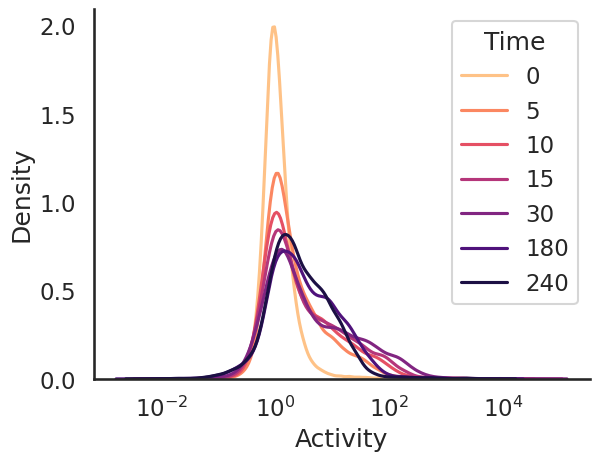

In [159]:
sns.set_context('talk')
sns.set_palette("magma_r", n_colors=7)
for time in ["0", "5", "10", "15", "30", "180", "240"]:
    sns.kdeplot(final_means_cat[time], log_scale = True, label = time)
plt.legend(frameon=True, facecolor='none', title = "Time")
sns.despine()
plt.xlabel("Activity")

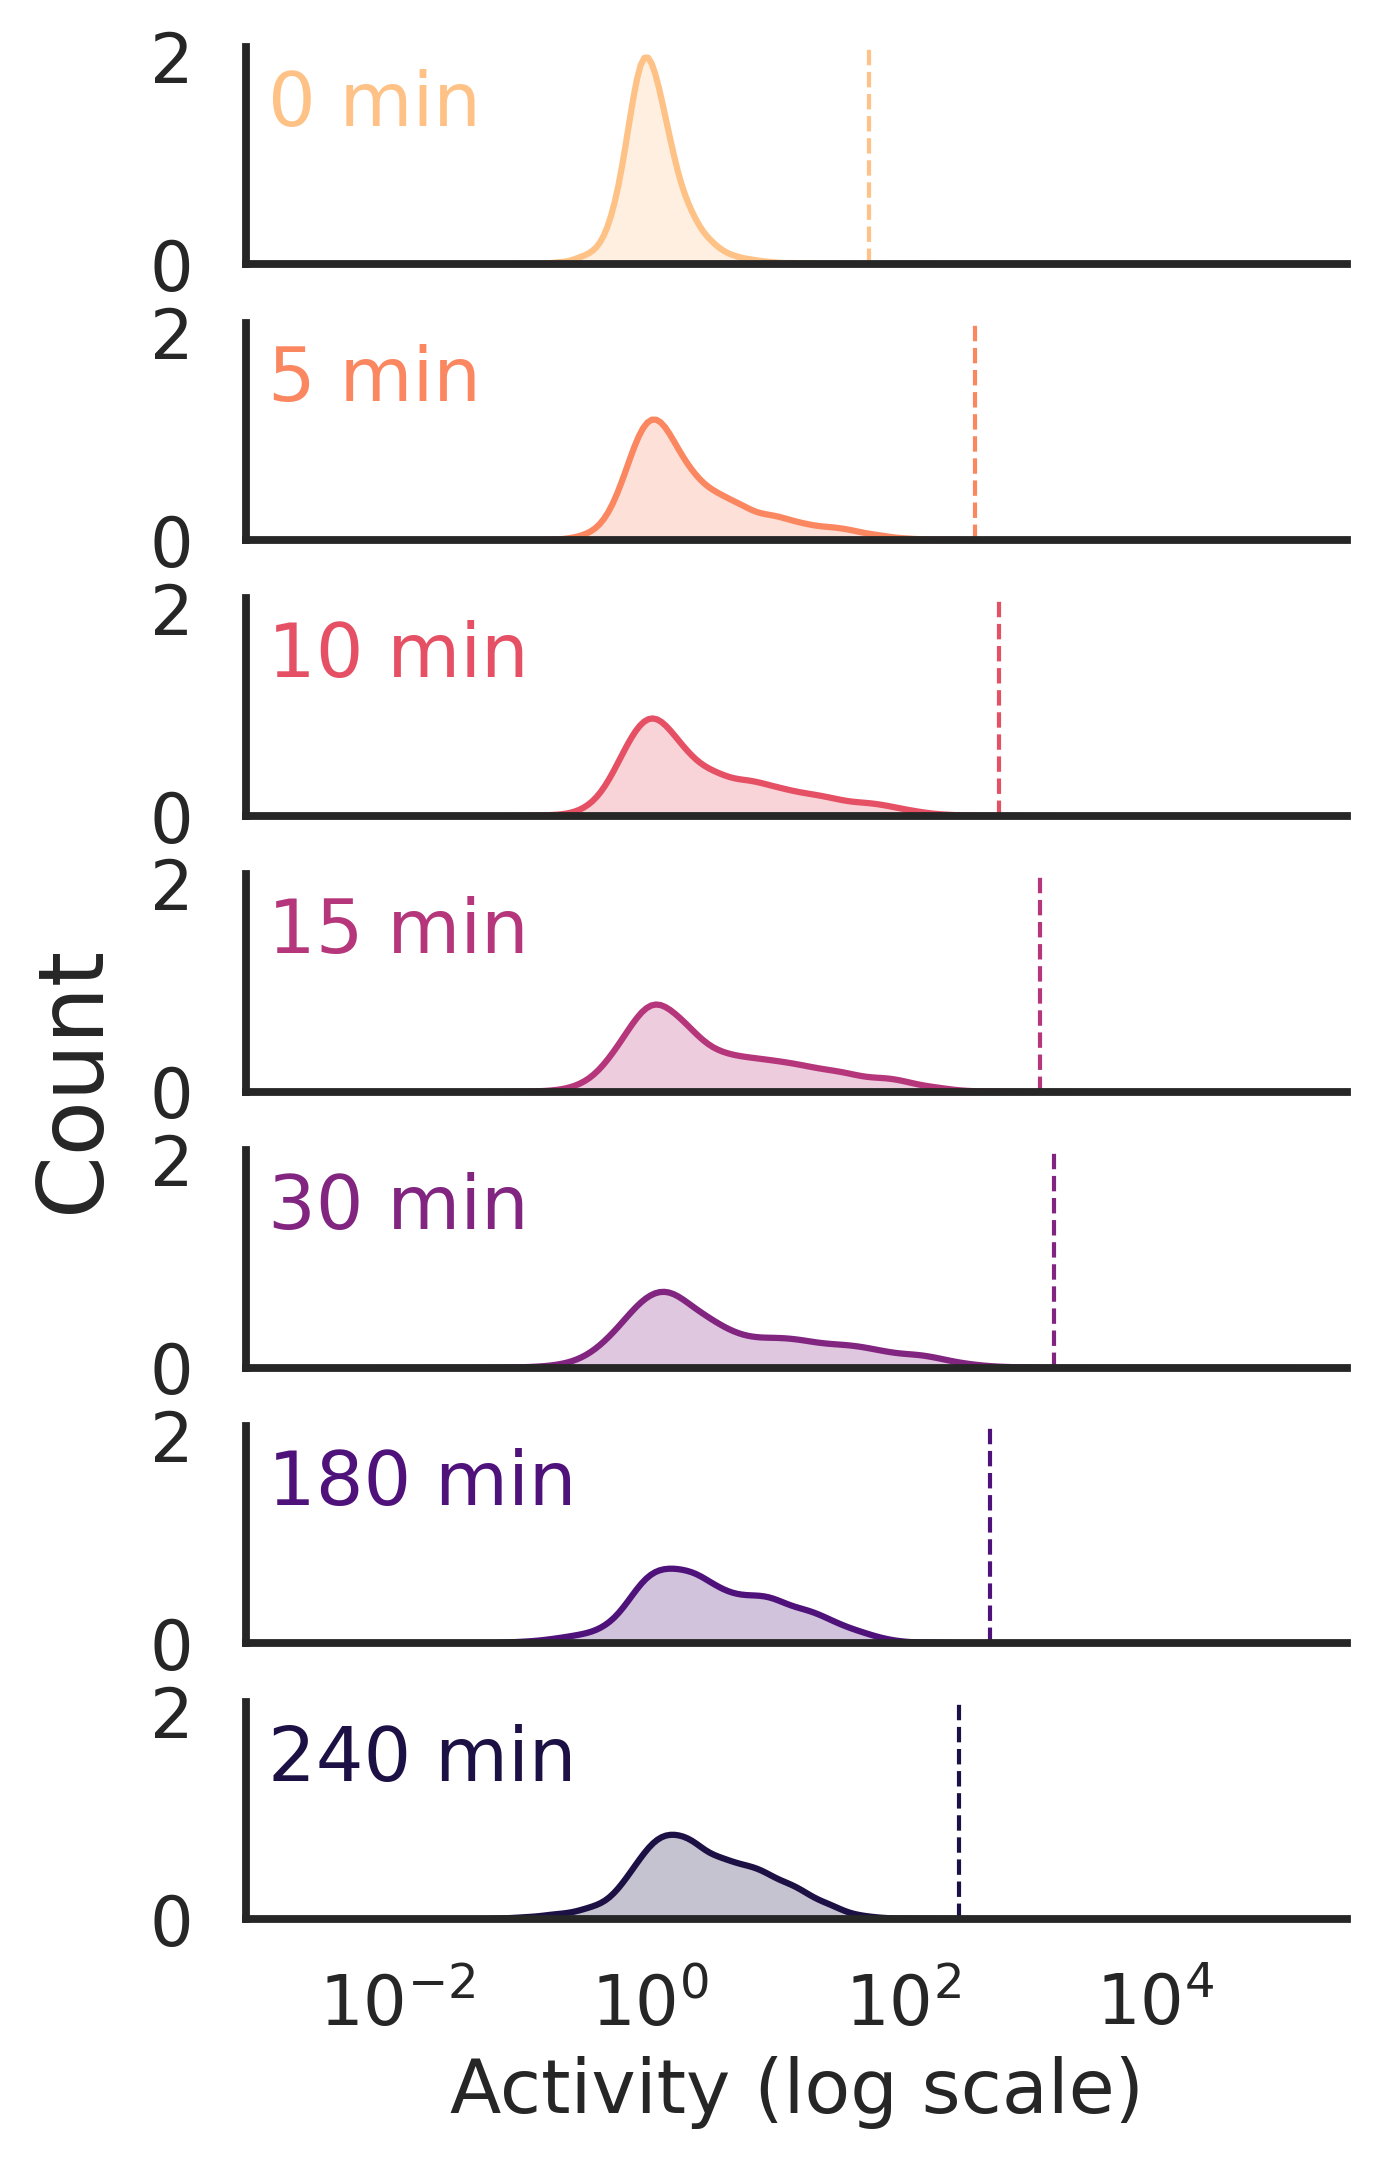

,Time,Mean,SD,Upper
0,0,2.951927,25.798981,54.549889
1,5,11.530841,180.214899,371.960639
2,10,19.281497,283.184264,585.650025
3,15,28.415487,598.541236,1225.497960
4,30,43.476106,763.346151,1570.168407
5,180,17.730551,236.128808,489.988167
6,240,11.851191,134.701072,281.253336


In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

timepoints = ["0", "5", "10", "15", "30", "180", "240"]
n = len(timepoints)

sns.set_context('talk')

# Generate the magma_r palette
palette = sns.color_palette("magma_r", n_colors=n)

# DataFrame to store mean + 2 SD
stats_df = pd.DataFrame(columns=["Time", "Mean", "SD", "Upper"])

# Create subplots
fig, axes = plt.subplots(n, 1, figsize=(4, 1*n), sharex=True, sharey=True, dpi = 300)

for i, time in enumerate(timepoints):
    ax = axes[i]
    data = final_means_cat[time].dropna()  # ensure no NaNs
    color = palette[i]
    
    # Compute mean and SD
    mean = data.mean()
    sd = data.std()
    upper = mean + 2*sd
    
    # Store in DataFrame
    stats_df = pd.concat([stats_df, pd.DataFrame({
        "Time": [time],
        "Mean": [mean],
        "SD": [sd],
        "Upper": [upper]
    })], ignore_index=True)
    
    # Plot KDE with assigned color
    sns.kdeplot(data, log_scale=True, ax=ax, fill=True, color=color)
    
    # Plot vertical line for mean + 2 SD with same color
    ax.axvline(upper, color=color, linestyle='--', lw=1)
    
    # Y-axis label
    ax.set_ylabel("", rotation=0, ha='right', x=-0.1, va='center')
    
    # Add time text in top-left corner with corresponding color
    ax.text(0.02, 0.9, f"{time} min", color=color,
            ha='left', va='top', transform=ax.transAxes)
    
    sns.despine(ax=ax)

axes[-1].set_xlabel("Activity (log scale)")
plt.tight_layout(pad=0)
fig.supylabel("Count", x = -0.1)
plt.show()

# Show the stats DataFrame
stats_df


In [161]:
final_means_cat

Time,0,10,15,180,240,30,5,Vmax,Avg_StdDev,Activity,FirstExceed
Tile,,,,,,,,,,,
AAACAAAGAGCTACTCCATTGACTCCAGTTGTTCCAGAATCTGATGATCCAGTTGCTTTGAAGAGAGCTAGAAATACTGAAGCTGCTAGAAGATCTAGAGCTAGGAAATTGGAAAGAATG,1.254211,1.062693,1.532920,1.240728,1.206545,1.787659,1.351119,1.787659,0.431083,inactive,None
AAACAAAGATCTCAACCATTGCAACCAATTATTATTGATGATATTAAAGATGCTGCTGCTTTGAAGAGAGCTAAGAATACTGAAGCTGCTAGAAGATCTAGAGCTAGGAAGATGGAAAGA,1.265805,1.819540,1.700459,2.317024,2.080985,1.885667,2.077828,2.317024,0.356520,inactive,None
AAACAAATGTATATTGGTTCTAATAAACCATTGGGTAAAGATCATAGAGGTTATAATGCTCATAATTGGAAACAATGTGCTATTTACTTTCATATTAGATATCCAAATGTTTCTAATTGT,1.166629,1.000460,0.730895,0.709995,0.732983,0.797948,1.621634,1.621634,0.269212,inactive,None
AAACAACCAGATGTTGCTACTTGGGATGCTCATTCTAATAAAGGTCAATGTTTGTTAAATTCTGGTGGTTCTGCTAGACCATTGATTATTTGGTTGCCACATTCTCACTTTAAAGAATAT,1.984682,1.299895,1.467031,1.668606,1.693269,1.947597,0.934068,1.984682,0.981397,inactive,None
AAACAAGATAAAGATGATGTTACTTCTGAAGTTGCTGATAGAAGATGTAAATCTACTTCTGATTCTCAAGATGTTTATGATAAACCAGGTGAATCTGAATCTCCAGAAAGAACTGAATAT,0.679833,1.127691,1.071415,1.504457,1.322705,1.427080,0.959878,1.504457,0.396125,inactive,None
...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGATGGTTTGGATGCTGCTTCTTTGGCTATGTTTGATACTCAACAATTGGATAAAGTTCAAGCATTTGTTTCTGGTACTGTTTCTCCTAAAGATTTGCATGTTGATACTGCTCCA,1.124169,18.108378,25.314241,15.885584,11.023455,38.055564,10.208349,38.055564,2.313608,active,None
TTTGTTGCTTCTCCAACATTTAATCATAAATTCTCTTCTTCTAATGCATTTACTACTGAACAAATGAAGACATTTGATCCAGAAGCTGCATTTAATGAATTGTTCTCTCCAGAGTTCTCT,1.676623,30.615512,26.635877,24.434864,17.924639,73.708402,16.050106,73.708402,6.074092,active,None
TTTGTTGGTGATGGTGATTTGGATCAATCTTTGGCTGCTGATCCATGGTATCCATTGTTTCCAGAATCTGATAAATTGGATCAACCAACTAAAGTTGAACAATCTCCATTGATTATTGAT,1.981525,14.324264,20.019784,19.689651,12.861237,42.340589,6.746955,42.340589,2.990464,active,None


In [162]:
# Create a mapping from time -> Upper
stats_df_map = stats_df.set_index('Time')['Upper'].to_dict()
stats_df_map

{'0': 54.54988862047477,
 '5': 371.96063850314175,
 '10': 585.6500253973253,
 '15': 1225.497959607217,
 '30': 1570.168407286395,
 '180': 489.98816699610916,
 '240': 281.2533359586415}

In [163]:
# Function to find first time exceeding Upper
def first_exceed(row):
    for t in ["5", "10", "15", "30", "180", "240"]:
        if row[t] > stats_df_map[t]:
            return t
    return None  # if no value exceeds

In [164]:
# Apply to each row
final_means_cat['FirstExceed'] = final_means_cat.apply(first_exceed, axis=1)
final_means_cat

Time,0,10,15,180,240,30,5,Vmax,Avg_StdDev,Activity,FirstExceed
Tile,,,,,,,,,,,
AAACAAAGAGCTACTCCATTGACTCCAGTTGTTCCAGAATCTGATGATCCAGTTGCTTTGAAGAGAGCTAGAAATACTGAAGCTGCTAGAAGATCTAGAGCTAGGAAATTGGAAAGAATG,1.254211,1.062693,1.532920,1.240728,1.206545,1.787659,1.351119,1.787659,0.431083,inactive,None
AAACAAAGATCTCAACCATTGCAACCAATTATTATTGATGATATTAAAGATGCTGCTGCTTTGAAGAGAGCTAAGAATACTGAAGCTGCTAGAAGATCTAGAGCTAGGAAGATGGAAAGA,1.265805,1.819540,1.700459,2.317024,2.080985,1.885667,2.077828,2.317024,0.356520,inactive,None
AAACAAATGTATATTGGTTCTAATAAACCATTGGGTAAAGATCATAGAGGTTATAATGCTCATAATTGGAAACAATGTGCTATTTACTTTCATATTAGATATCCAAATGTTTCTAATTGT,1.166629,1.000460,0.730895,0.709995,0.732983,0.797948,1.621634,1.621634,0.269212,inactive,None
AAACAACCAGATGTTGCTACTTGGGATGCTCATTCTAATAAAGGTCAATGTTTGTTAAATTCTGGTGGTTCTGCTAGACCATTGATTATTTGGTTGCCACATTCTCACTTTAAAGAATAT,1.984682,1.299895,1.467031,1.668606,1.693269,1.947597,0.934068,1.984682,0.981397,inactive,None
AAACAAGATAAAGATGATGTTACTTCTGAAGTTGCTGATAGAAGATGTAAATCTACTTCTGATTCTCAAGATGTTTATGATAAACCAGGTGAATCTGAATCTCCAGAAAGAACTGAATAT,0.679833,1.127691,1.071415,1.504457,1.322705,1.427080,0.959878,1.504457,0.396125,inactive,None
...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGATGGTTTGGATGCTGCTTCTTTGGCTATGTTTGATACTCAACAATTGGATAAAGTTCAAGCATTTGTTTCTGGTACTGTTTCTCCTAAAGATTTGCATGTTGATACTGCTCCA,1.124169,18.108378,25.314241,15.885584,11.023455,38.055564,10.208349,38.055564,2.313608,active,None
TTTGTTGCTTCTCCAACATTTAATCATAAATTCTCTTCTTCTAATGCATTTACTACTGAACAAATGAAGACATTTGATCCAGAAGCTGCATTTAATGAATTGTTCTCTCCAGAGTTCTCT,1.676623,30.615512,26.635877,24.434864,17.924639,73.708402,16.050106,73.708402,6.074092,active,None
TTTGTTGGTGATGGTGATTTGGATCAATCTTTGGCTGCTGATCCATGGTATCCATTGTTTCCAGAATCTGATAAATTGGATCAACCAACTAAAGTTGAACAATCTCCATTGATTATTGAT,1.981525,14.324264,20.019784,19.689651,12.861237,42.340589,6.746955,42.340589,2.990464,active,None


In [165]:
final_means_cat["FirstExceed"].value_counts()

FirstExceed
5      34
180     9
240     9
10      4
15      2
Name: count, dtype: int64

In [166]:
final_means_cat_at_least_one_active = final_means_cat.dropna()
final_means_cat_at_least_one_active["FirstExceed"] = final_means_cat_at_least_one_active["FirstExceed"].astype(int)
final_means_cat_at_least_one_active

Time,0,10,15,180,240,30,5,Vmax,Avg_StdDev,Activity,FirstExceed
Tile,,,,,,,,,,,
AACTTCTCTACTACTTCTGGTTCTTCTTCTTCTTTGAATAATATTTCTACATTTGACTTTACTTCATTTAATACTGATCATCATCAACAAACTTGGTTGCCAACTCCACCACCACCACAA,100.263737,362.249935,396.145263,1033.088400,564.631426,707.656112,367.146334,1033.088400,397.413294,active,180
AAGATGGTCTTGGAAGGTTCTTCTCCATCTACTTTGAAACATTCTCAAATGAGAAGAACTGCTTCTTCTCAATCTACTTCTTCTTCTGATTTGCAAGGTTTGTCTGACTTTGCTGCTGTT,151.561607,683.360795,645.145012,713.902648,483.890511,677.333346,568.256923,713.902648,157.766717,active,5
AATACTGAAGCTGCTAGGAAATCTAGAGCTAGGAAATTGGAAAGACAAGGTGATATGGAAAGAAGAATTGCTGAATTGTCTAAAGAATTGGAAGAAACTAGACAAATGGTTGAGTTCTGG,323.098776,706.406572,941.294041,929.807519,1641.678443,913.853926,253.928024,1641.678443,521.382571,active,10
AATAGACCACCAGTTCCATTGTTTCCAGCTACTAATGTTACTCCACAATATAATCAGAAACAATTGCAACAATTGCAACAATTCTATCAAAGAAGAATTATGTCTACTCCAAATATTGGT,172.143801,69.093877,55.642633,519.034026,319.256405,67.647183,96.664111,519.034026,115.037861,active,180
AATGAACCAGCTCCAACTCAAACTCCAAATATTCAAACTGTTTCTCCTAAAGATTTGATGGTTGAATCTATGTCTGCTCCACCATCTGGTGCTTATACTGATTTGACTACTCCAGGTACT,87.171164,279.588038,219.220940,670.951884,354.525303,286.964044,152.212622,670.951884,349.534778,active,180
AATGATTCTGACTTTAATAATAATGAATTGGATTCTGCTGTTGTTGATGCATTCTTCTCTTCTACTTCTGATTCTACTCCAATGTTTGAATTTGAATCTTTGGATGGTACTAATAATGAT,43.337026,1268.674294,2050.052410,438.121984,230.407930,2041.252358,696.972246,2050.052410,166.139674,active,5
AATGCTAATATGAATATTCAAGATTTGGAAGACTTTACTGGATTTGAAGGTGGTGCTACTACTGCTTATTCTTCTCCAGGTGCTCCATCTATCTTTGATTTGCCAATGGGTTCTAATGCT,12.534025,12.269911,14.695822,12.360336,353.615373,21.226633,5.730090,353.615373,47.969425,active,240
ACTAGACCACAAGTTCCATTGTTCTCTCAATCTACTGGTAATATTCCACAAACTCCAAATATGGTTATGCAAGATATGGATTTGTTTGATGACTTTACTGCATTTGAAGGTGGTGCTTCT,114.040931,2107.327104,4005.776505,1666.436632,768.465723,6353.028645,1111.507196,6353.028645,1092.341605,active,5
ACTCCAACTCCATCTATTCCAACTACTACTCCAGAATCTTCATTCTTGGAACCATTAAATTCTTCTTTGGCTTCTTGTTCATTCTCTTCTCCATCTTCTTCTCCATTTGACTTTACTTCT,119.297368,4.371266,349.401322,6.888167,905.563226,7.358886,4.353225,905.563226,234.306621,active,240


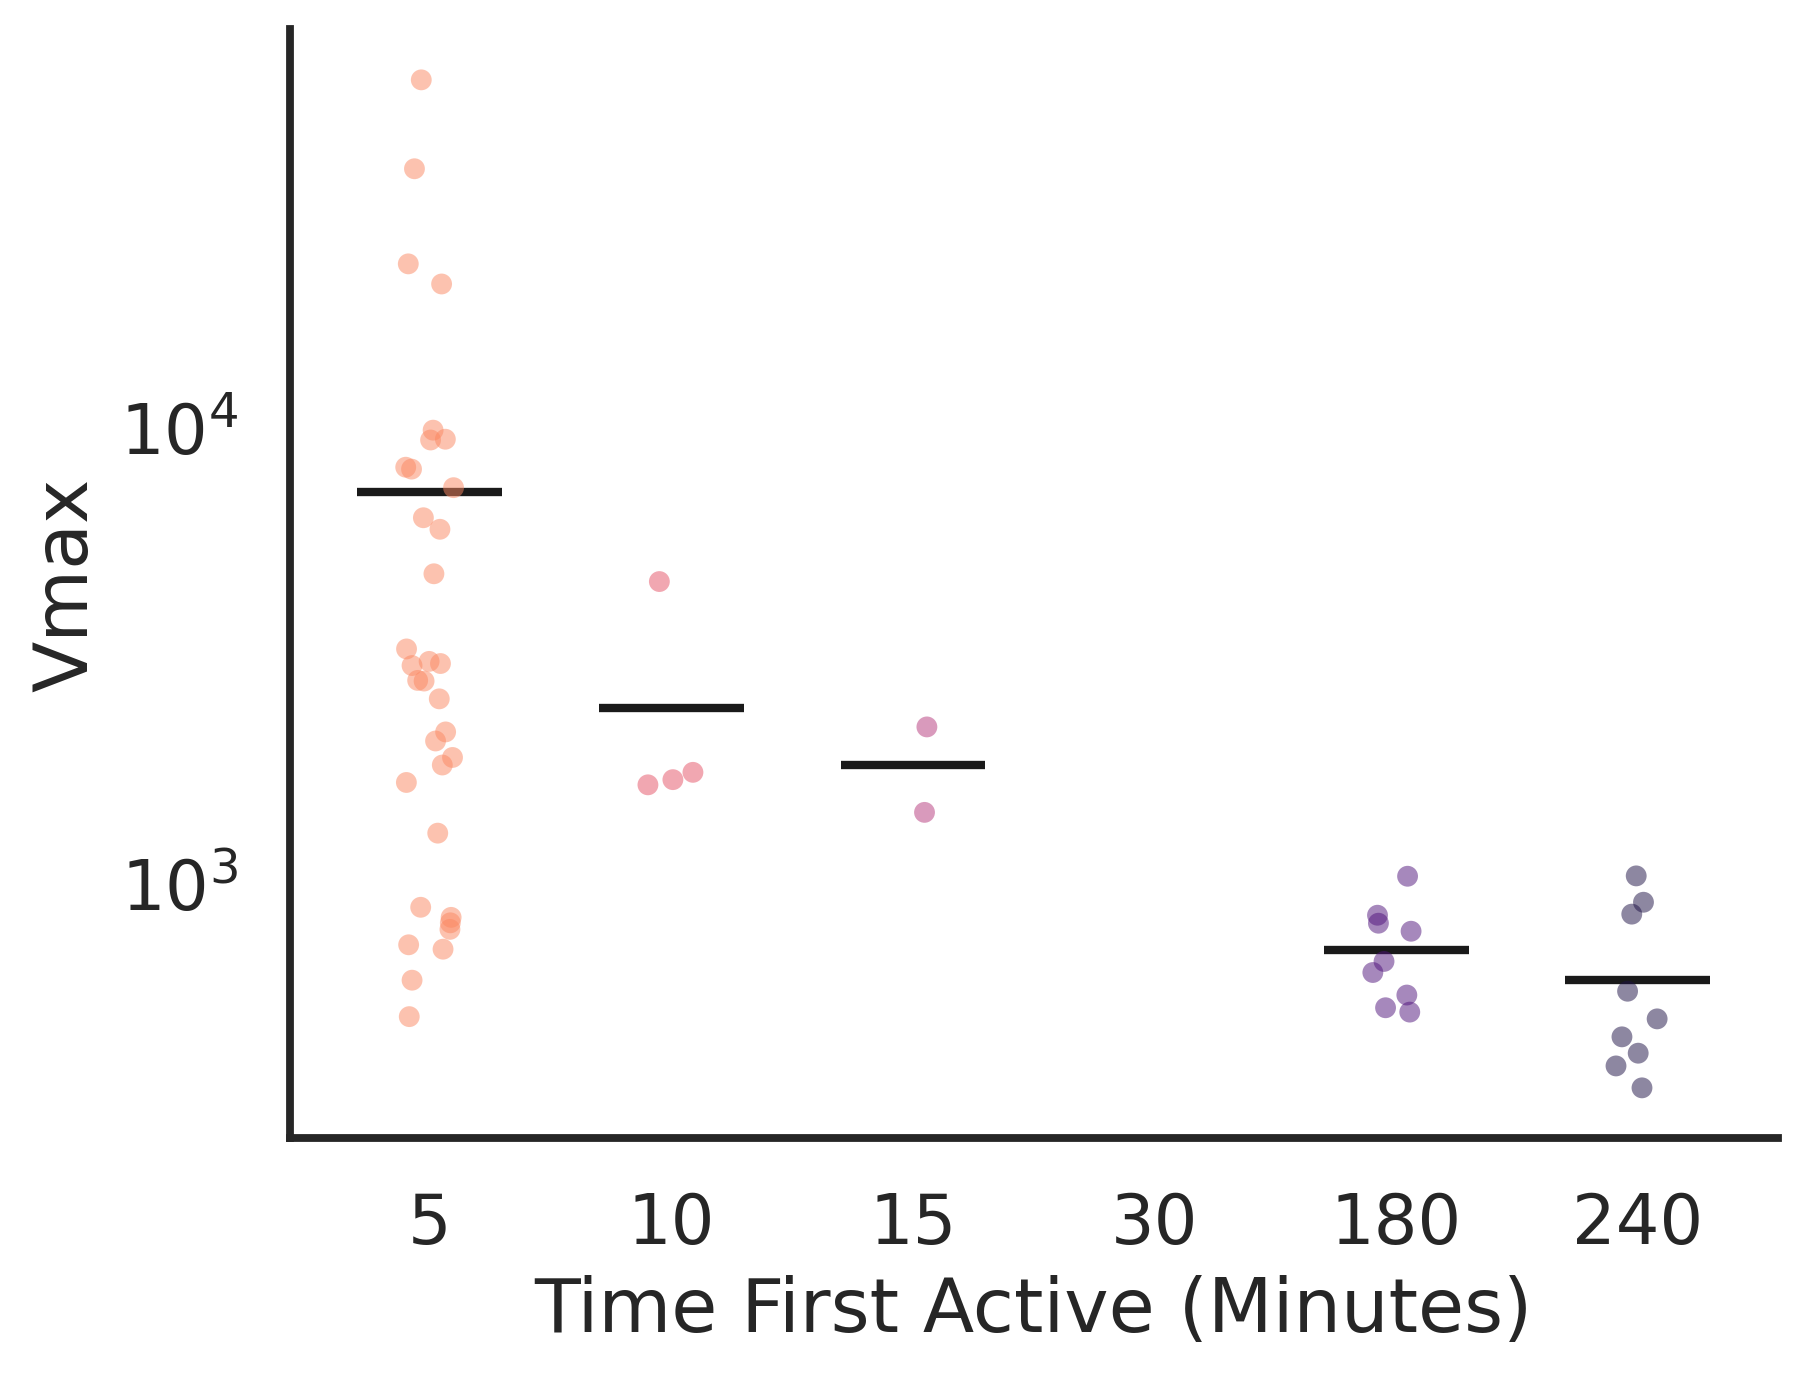

In [363]:
plt.figure(dpi = 300)
sns.set_context('talk')

# Define full order including 30
time_order = [0, 5, 10, 15, 30, 180, 240]

# Stripplot with explicit order
ax = sns.stripplot(
    data=final_means_cat_at_least_one_active, 
    x="FirstExceed", y="Vmax", 
    palette="magma_r", alpha=0.5,
    order=time_order
)

# Compute means per FirstExceed
mean_vmax = final_means_cat_at_least_one_active.groupby("FirstExceed")["Vmax"].mean()

# Plot horizontal lines at mean Vmax per group (skip if mean not available)
for i, t in enumerate(time_order):
    if t in mean_vmax:
        plt.hlines(y=mean_vmax[t], xmin=i-0.3, xmax=i+0.3, colors='k', lw=2)

ax.set_yscale('log')
sns.despine()
plt.ylabel("Vmax")
plt.xlabel("Time First Active (Minutes)")
plt.show()

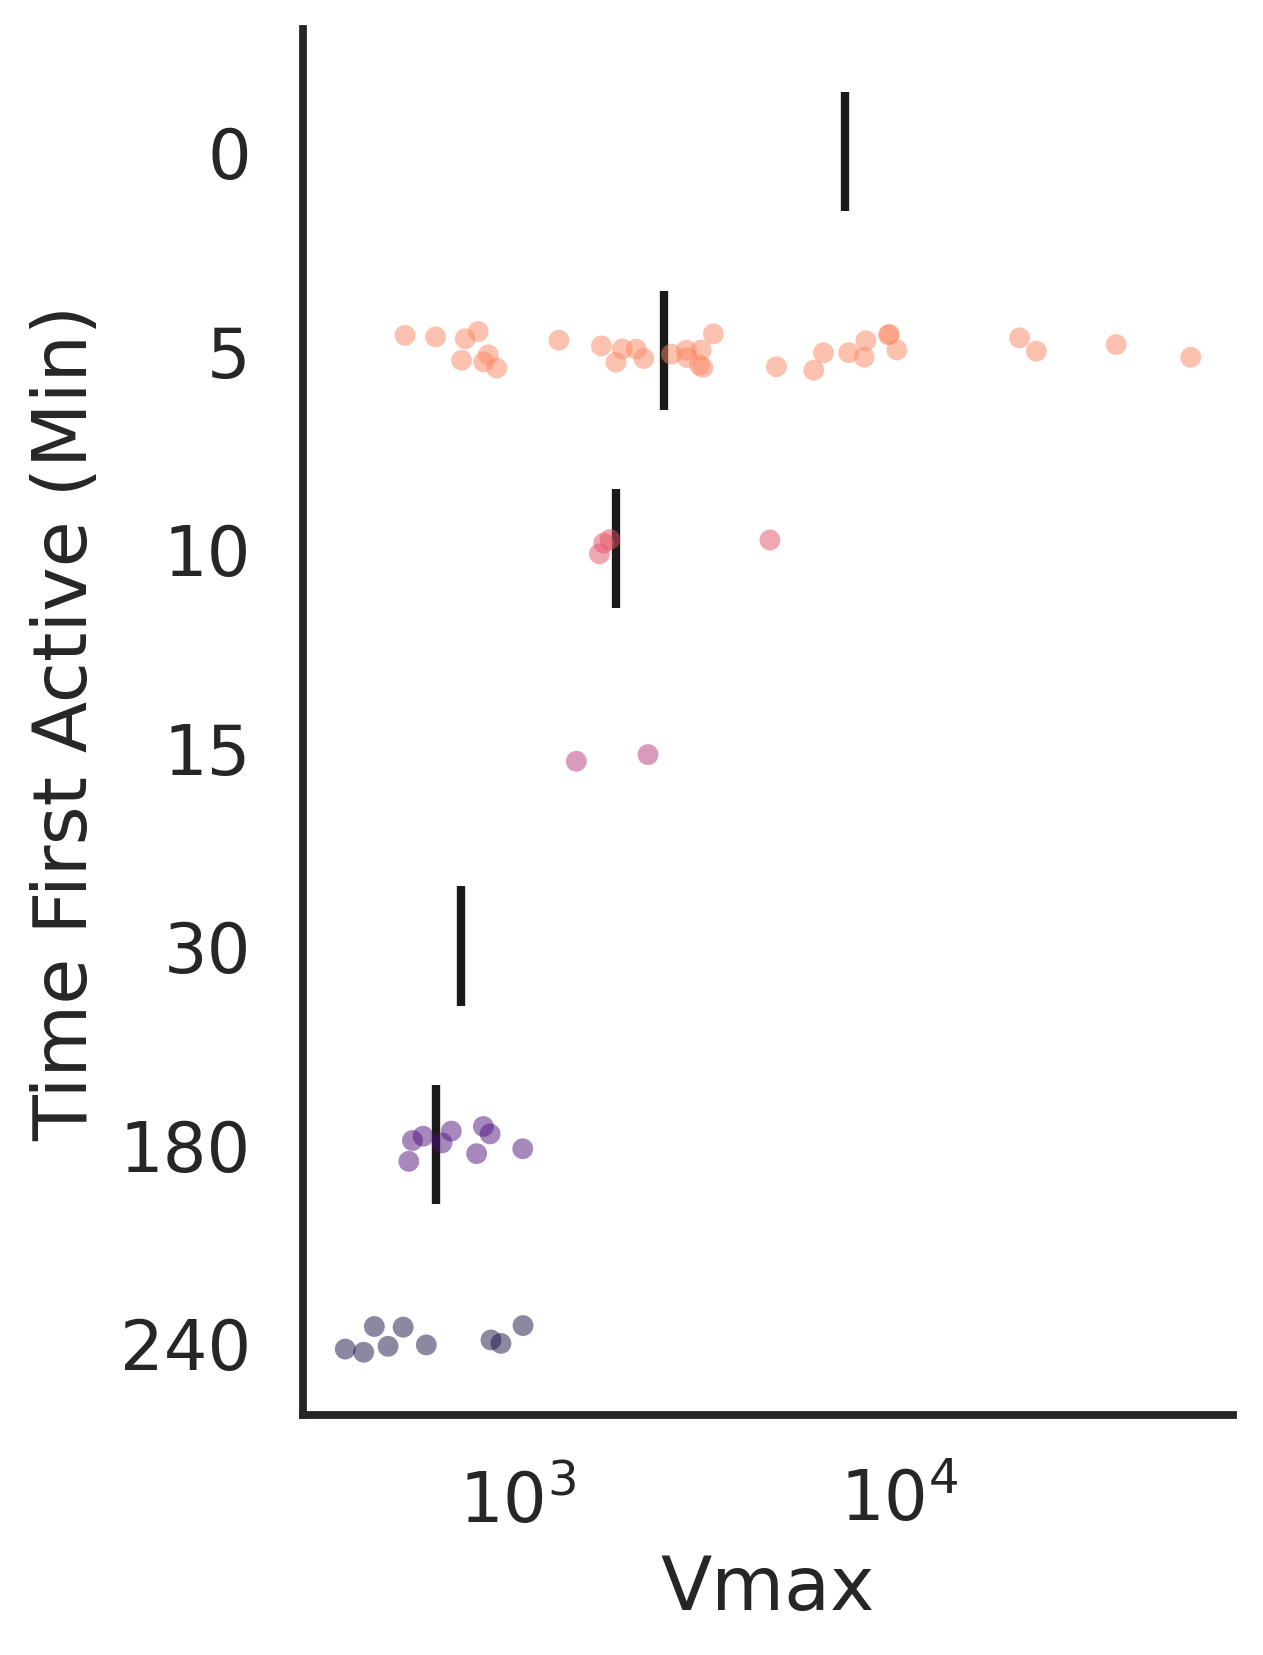

In [361]:
plt.figure(dpi=300, figsize = (4,6))

# Ensure FirstExceed is categorical with specified order
final_means_cat_at_least_one_active['FirstExceed'] = pd.Categorical(
    final_means_cat_at_least_one_active['FirstExceed'], 
    categories=[0, 5, 10, 15, 30, 180, 240], 
    ordered=True
)

# Stripplot with x and y switched
ax = sns.stripplot(
    data=final_means_cat_at_least_one_active,
    y="FirstExceed", x="Vmax",
    palette="magma_r", alpha=0.5
)

# Compute means per FirstExceed
mean_vmax = final_means_cat_at_least_one_active.groupby("FirstExceed")["Vmax"].mean()

# Plot vertical lines at mean Vmax for each category
for i, t in enumerate(time_order): 
    if t in mean_vmax: 
        plt.vlines(x=mean_vmax[t], ymin=i-0.3, ymax=i+0.3, colors='k', lw=2)

ax.set_xscale('log')
sns.despine()
plt.xlabel("Vmax")
plt.ylabel("Time First Active (Min)")
plt.show()


# 3. Sort-seq regression

In [170]:
# read in facs csv with activity data and control designation (EC did by hand in excel)
facs_f='/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/TREBLseq_finaldrafts/Gcn4OrthologData_ToShare_20240930_EC.csv'
facsdf_qc = pd.read_csv(facs_f, usecols=['Name','ArrayDNA','is_control',
                                         'Activity_SCglucose', 'TotalReads_BioRepA_BYS4', 'TotalReads_BioRepB_BYS4',
                                         'BioRep_A_mCherry','BioRep_A_mCherry_TotalReads','BioRep_B_mCherry','BioRep_B_mCherry_TotalReads', #mCherry 4 bin sorts
                                        'BioRep_A_GFP', 'BioRep_A_GFP_TotalReads','BioRep_B_GFP', 'BioRep_B_GFP_TotalReads', #GFP 4 bin sorts -- one of the replicates is very messed up
                                        ])
facsdf_qc['GFP_mean']=facsdf_qc[['BioRep_A_GFP','BioRep_B_GFP']].mean(axis=1)
facsdf_qc['mCherry_mean']=facsdf_qc[['BioRep_A_mCherry','BioRep_B_mCherry']].mean(axis=1)
facsdf_qc = facsdf_qc[(
    facsdf_qc['BioRep_A_mCherry_TotalReads']>=50) & (facsdf_qc['BioRep_B_mCherry_TotalReads']>=50) &(
        facsdf_qc['BioRep_A_GFP_TotalReads']>=50) & (facsdf_qc['BioRep_B_GFP_TotalReads']>=50)
    ]
facsdf_qc = facsdf_qc[(facsdf_qc['TotalReads_BioRepA_BYS4']>=1000) & (facsdf_qc['TotalReads_BioRepB_BYS4']>=1000) ]
facsdf_qc

,Name,is_control,ArrayDNA,TotalReads_BioRepA_BYS4,TotalReads_BioRepB_BYS4,BioRep_A_GFP_TotalReads,BioRep_A_GFP,BioRep_B_GFP_TotalReads,BioRep_B_GFP,BioRep_A_mCherry_TotalReads,BioRep_A_mCherry,BioRep_B_mCherry_TotalReads,BioRep_B_mCherry,Activity_SCglucose,GFP_mean,mCherry_mean
7,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g_36,experimental,GCTTCTGGTCAAGCTAATGCTAATTATCAAGCATTTACTGCTGGTT...,37745.0,27242.0,555.0,1069.575624,294.0,256.000000,1301.0,1914.455499,819.0,2495.171715,31637.986095,662.787812,2204.813607
8,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g_41,experimental,AATGCTAATTATCAAGCATTTACTGCTGGTTCTGCTTTGAATGGTC...,54447.0,34378.0,521.0,648.717628,569.0,268.428420,2706.0,1863.229267,716.0,1873.407563,35182.012737,458.573024,1868.318415
9,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g_46,experimental,GCATTTACTGCTGGTTCTGCTTTGAATGGTCCATCTTTGCCAGCTC...,53756.0,5256.0,784.0,1186.811484,64.0,256.000000,2109.0,1028.931403,80.0,855.631328,65569.941168,721.405742,942.281366
10,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g_51,experimental,TCTGCTTTGAATGGTCCATCTTTGCCAGCTCCATCTTTGTTTGCTG...,6275.0,86566.0,58.0,2912.584135,1438.0,598.087653,333.0,596.539632,4863.0,1520.385633,41694.074991,1755.335894,1058.462632
11,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g_56,experimental,CCATCTTTGCCAGCTCCATCTTTGTTTGCTGGTCATGGTCCAGAAG...,19935.0,4774.0,479.0,361.582465,141.0,256.000000,1673.0,3213.641420,524.0,3169.107634,18947.873984,308.791233,3191.374527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20813,Gnc4Lib_Disorder_HIGH_0,high,TCTACTGATTATACTCCAATGTTTGAATATGAAACTTATGAAGATA...,3225.0,23456.0,414.0,8782.000000,2446.0,9064.000000,94.0,1664.822094,479.0,1331.972632,261410.705323,8923.000000,1498.397363
20814,Gnc4Lib_Disorder_HIGH_0,high,ATGACTGATTCTACTCCAATGTTTGAATATGAATTGACTGAGAATA...,64713.0,46036.0,10295.0,4506.455793,8034.0,5156.528478,2549.0,3124.915008,1258.0,2875.423105,152798.870307,4831.492136,3000.169056
20818,Gnc4Lib_Charge_HIGH_0,mid,TCTACTGATTCTACTCCAATGTTTGAATATCAGAATTTGGAGAATA...,4430.0,53110.0,452.0,3363.151895,7755.0,3243.398807,124.0,1860.267447,2115.0,1947.655400,113197.558297,3303.275351,1903.961424
20820,Gnc4Lib_Disorder_HIGH_0,high,TCTACTGATTATACTCCAATGTTTGAATATGAAACTTATGAAGATA...,3225.0,23456.0,414.0,8782.000000,2446.0,9064.000000,94.0,1664.822094,479.0,1331.972632,261410.705323,8923.000000,1498.397363


In [172]:
# inner join the df's 
qcdf = pd.merge(concatenated_df[['Tile', 'AD_BC', 'RPTR_BC', 
                                 'RPTR_UMIs', 'AD_UMIs',
                                 'Ratio_negCTRLnorm', 'Time','sample'
                                ]], 
                facsdf_qc[['Name', 'ArrayDNA', 'is_control',
                                           'GFP_mean', 'mCherry_mean', 'Activity_SCglucose']],
                   left_on = 'Tile', right_on = 'ArrayDNA',
                   how= 'inner')
qcdf = qcdf.drop(columns=['ArrayDNA', ])
qcdf

,Tile,AD_BC,RPTR_BC,RPTR_UMIs,AD_UMIs,Ratio_negCTRLnorm,Time,sample,Name,is_control,GFP_mean,mCherry_mean,Activity_SCglucose
0,GGTACTATTTCTCCTAAAGATTTGATGATGGATGCTTCTGTTCCAC...,ACTCGGAATTG,TATACATCCACCAT,402,646,5.651387,5,3,Eurotiomycetes_jgi|Penatra1|67166|gm1.1253_g_256,experimental,2550.414931,3813.713778,71546.924661
1,ATGTTTACTGATTTGGATGTTGCTGGTCATGAAGATTGGCCATCTT...,AAGTTCTTTCA,CTATTCCGAAATAT,1012,167,55.033299,5,3,Eurotiomycetes_jgi|Penatra1|67166|gm1.1253_g_296,experimental,8798.171241,1017.694945,261940.998463
2,TTGGATTTGGATGACTTTACTGGATTTGAAGGTGGTGCTTCTACTA...,TCTTAGGCTCG,AAAGTTCTCAGACA,690,917,6.833470,5,3,Sordariomycetes_jgi|Colac2|683025|estExt_Genew...,experimental,3248.307011,2321.034628,102890.752186
3,CAAAGACCAACTAGACCACAAGTTCCATTGTTCTCTCAATCTACTG...,GCCCTTGTATT,TTAGTATTTTATCT,140,533,2.385406,5,3,Leotiomycetes_jgi|Rhier1|657659|fgenesh1_pg.13...,experimental,1762.120378,2637.450831,46665.516224
4,TTGTTTATGGATGCTTCTGCTCCACCATCTGCTTCATTTACTGATT...,GCTCGTTACCG,AAAAACTAATTCTA,459,111,37.553569,5,3,Eurotiomycetes_jgi|Aspind2_1|119317|CE119316_2...,experimental,5148.434170,2383.548911,161936.816547
...,...,...,...,...,...,...,...,...,...,...,...,...,...
124122,GCTAGATCTGTTACTAAACCATCTCATGTTGCTGGTGTTAATGCTA...,TTCAACCTGCT,AACGAATAAAACAA,109,379,0.725170,240,1,Afla_EED46972.1_AspergillusFlavusNRRL3357_131,experimental,270.500000,1081.691640,51021.993644
124123,CCAAAATCTGGTTCTAGGAAACATTCTTCTGTTGCTGGTGTTAATT...,TGATGTACGGT,TGTTAGGTGATAAC,22,148,0.374812,240,1,Xylonomycetes_jgi|Trigu1|1045435|fgenesh1_pg.2...,experimental,370.737233,2473.781472,23650.129864
124124,GGTTCTTCTGGTGAATATGATGTTGCTGGTTCTCAATGGTTCTCTT...,ACCGCGGGCCG,ATAATACGTGTACA,11,5,5.547214,240,1,Sordariomycetes_jgi|Verdah1|362640|estExt_Gene...,experimental,2594.613575,3341.401808,46857.078856
124125,GTTACTACTACTTCTTCTTCTTCTAGAAGGAAATCTGGTGGTTCTC...,CTTCCCTCCCT,CGCCACTCACCACT,30,63,1.200696,240,1,Sordariomycetes_jgi|Acral2|2034848|fgenesh1_kg...,experimental,270.500000,3068.675866,29693.319420


<Axes: xlabel='Activity_SCglucose', ylabel='Count'>

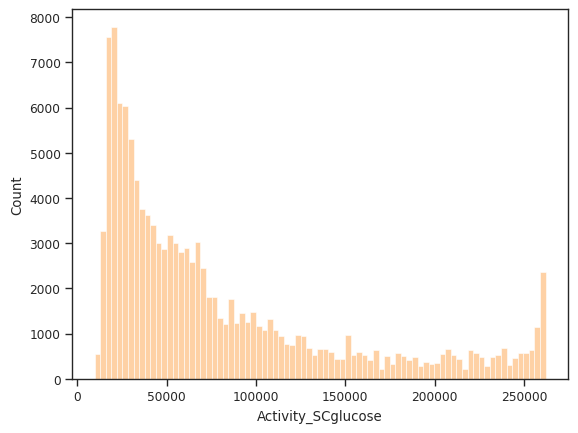

In [198]:
sns.histplot(qcdf["Activity_SCglucose"])

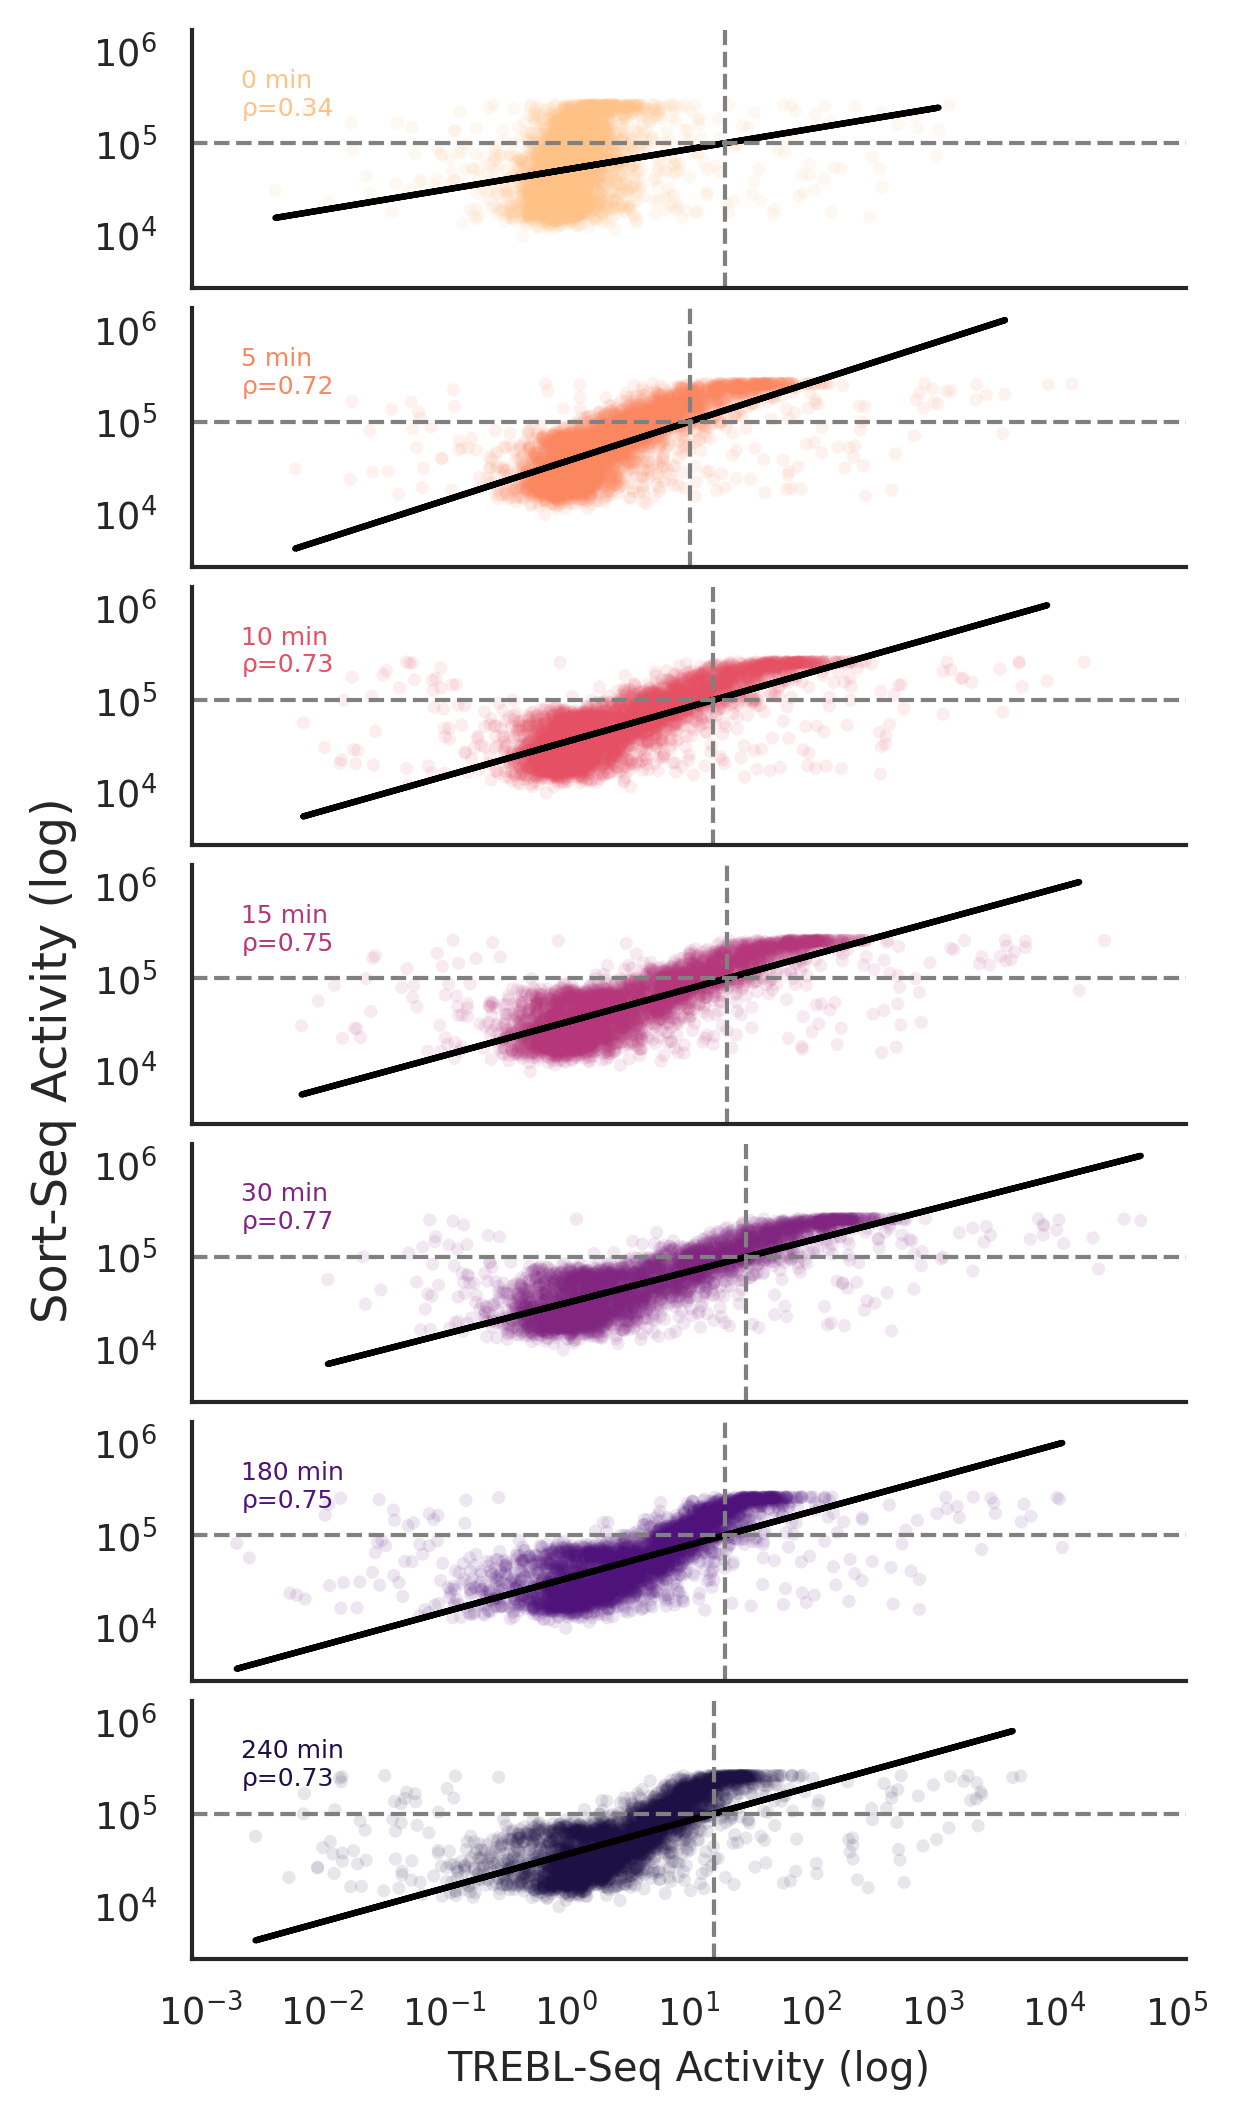

,Time,Slope_log,Intercept_log,Slope_lin,Intercept_lin,Spearman,TREBL_thresh
0,0,0.221785,4.711611,0.221785,51476.711634,0.337028,19.966825
1,5,0.429629,4.564701,0.429629,36702.981301,0.715907,10.308518
2,10,0.378881,4.543030,0.378881,34916.450033,0.734788,16.073265
3,15,0.364671,4.520794,0.364671,33173.707519,0.753153,20.610013
4,30,0.341724,4.495873,0.341724,31323.663766,0.769884,29.870764
5,180,0.365149,4.525608,0.365149,33543.507723,0.752672,19.914661
6,240,0.369011,4.553764,0.369011,35790.221826,0.732134,16.191083


In [226]:
timepoints = ["0", "5", "10", "15", "30", "180", "240"]
n = len(timepoints)

sns.set_context('paper')
sns.set_style('white')
palette = sns.color_palette("magma_r", n_colors=n)

regression_df = pd.DataFrame(columns=[
    "Time", "Slope_log", "Intercept_log", "Slope_lin", "Intercept_lin", 
    "Spearman", "TREBL_thresh"
])

fig, axes = plt.subplots(n, 1, figsize=(4, n*1), sharex=True, sharey=True, dpi=300)

# Define y-axis limits for linear portion (Sort-Seq Activity)
y_min, y_max = 1, 250000
y_thresh = 100000  # Sort-Seq threshold for TREBL calculation

for i, time in enumerate(timepoints):
    ax = axes[i]
    color = palette[i]

    df_time = qcdf[qcdf['Time']==time]
    df_time = df_time[["Tile", "Ratio_negCTRLnorm", "Activity_SCglucose"]].groupby("Tile").mean()

    x = df_time['Ratio_negCTRLnorm'].values
    y = df_time['Activity_SCglucose'].values

    # Mask linear portion based on y-axis
    mask = (y >= y_min) & (y <= y_max)
    x_lin = x[mask]
    y_lin = y[mask]

    # Scatter plot (all points lightly colored)
    ax.scatter(x, y, alpha=0.1, s=10, color=color, edgecolor='none')
    
    # Fit log-log regression only on linear portion
    log_x = np.log10(x_lin)
    log_y = np.log10(y_lin)
    slope_log, intercept_log, r_value, p_value, std_err = linregress(log_x, log_y)

    # Non-log coefficients
    slope_lin = slope_log
    intercept_lin = 10**intercept_log  # y = intercept_lin * x^slope_lin

    # Fit line for plotting
    y_fit = intercept_lin * x_lin**slope_lin
    ax.plot(x_lin, y_fit, color='black', lw=1.5)

    # Calculate TREBL threshold corresponding to Sort-Seq threshold
    x_thresh = (y_thresh / intercept_lin) ** (1 / slope_lin)

    # Draw horizontal and vertical lines
    ax.axhline(y=y_thresh, color='gray', linestyle='--', lw=1)
    ax.axvline(x=x_thresh, color='gray', linestyle='--', lw=1)

    # Spearman correlation on linear portion
    spearman_corr, _ = spearmanr(x_lin, y_lin)
    ax.text(0.05, 0.85, f'{time} min\nρ={spearman_corr:.2f}', transform=ax.transAxes,
            fontsize=6, ha='left', va='top', color=color)

    # Save all info in dataframe
    regression_df = pd.concat([regression_df, pd.DataFrame({
        "Time": [time],
        "Slope_log": [slope_log],
        "Intercept_log": [intercept_log],
        "Slope_lin": [slope_lin],
        "Intercept_lin": [intercept_lin],
        "Spearman": [spearman_corr],
        "TREBL_thresh": [x_thresh]
    })], ignore_index=True)

    ax.set_xscale('log')
    ax.set_yscale('log')
    sns.despine(ax=ax)

    if i == n-1:
        ax.set_xlabel("TREBL-Seq Activity (log)")
    ax.set_ylabel("")

fig.supylabel("Sort-Seq Activity (log)")
plt.tight_layout(pad=0.5)
plt.show()

regression_df


In [227]:
final_means_cat

Time,0,10,15,180,240,30,5,Vmax,Avg_StdDev,Activity,FirstExceed
Tile,,,,,,,,,,,
AAACAAAGAGCTACTCCATTGACTCCAGTTGTTCCAGAATCTGATGATCCAGTTGCTTTGAAGAGAGCTAGAAATACTGAAGCTGCTAGAAGATCTAGAGCTAGGAAATTGGAAAGAATG,1.254211,1.062693,1.532920,1.240728,1.206545,1.787659,1.351119,1.787659,0.431083,inactive,None
AAACAAAGATCTCAACCATTGCAACCAATTATTATTGATGATATTAAAGATGCTGCTGCTTTGAAGAGAGCTAAGAATACTGAAGCTGCTAGAAGATCTAGAGCTAGGAAGATGGAAAGA,1.265805,1.819540,1.700459,2.317024,2.080985,1.885667,2.077828,2.317024,0.356520,inactive,None
AAACAAATGTATATTGGTTCTAATAAACCATTGGGTAAAGATCATAGAGGTTATAATGCTCATAATTGGAAACAATGTGCTATTTACTTTCATATTAGATATCCAAATGTTTCTAATTGT,1.166629,1.000460,0.730895,0.709995,0.732983,0.797948,1.621634,1.621634,0.269212,inactive,None
AAACAACCAGATGTTGCTACTTGGGATGCTCATTCTAATAAAGGTCAATGTTTGTTAAATTCTGGTGGTTCTGCTAGACCATTGATTATTTGGTTGCCACATTCTCACTTTAAAGAATAT,1.984682,1.299895,1.467031,1.668606,1.693269,1.947597,0.934068,1.984682,0.981397,inactive,None
AAACAAGATAAAGATGATGTTACTTCTGAAGTTGCTGATAGAAGATGTAAATCTACTTCTGATTCTCAAGATGTTTATGATAAACCAGGTGAATCTGAATCTCCAGAAAGAACTGAATAT,0.679833,1.127691,1.071415,1.504457,1.322705,1.427080,0.959878,1.504457,0.396125,inactive,None
...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGATGGTTTGGATGCTGCTTCTTTGGCTATGTTTGATACTCAACAATTGGATAAAGTTCAAGCATTTGTTTCTGGTACTGTTTCTCCTAAAGATTTGCATGTTGATACTGCTCCA,1.124169,18.108378,25.314241,15.885584,11.023455,38.055564,10.208349,38.055564,2.313608,active,None
TTTGTTGCTTCTCCAACATTTAATCATAAATTCTCTTCTTCTAATGCATTTACTACTGAACAAATGAAGACATTTGATCCAGAAGCTGCATTTAATGAATTGTTCTCTCCAGAGTTCTCT,1.676623,30.615512,26.635877,24.434864,17.924639,73.708402,16.050106,73.708402,6.074092,active,None
TTTGTTGGTGATGGTGATTTGGATCAATCTTTGGCTGCTGATCCATGGTATCCATTGTTTCCAGAATCTGATAAATTGGATCAACCAACTAAAGTTGAACAATCTCCATTGATTATTGAT,1.981525,14.324264,20.019784,19.689651,12.861237,42.340589,6.746955,42.340589,2.990464,active,None


In [250]:
# Make sure time columns are strings matching regression_df 'Time'
time_cols = ["5","10","15","30","180","240"]

# Create a dictionary mapping time -> TREBL_thresh
trebl_thresh_dict = dict(zip(regression_df['Time'].astype(str), regression_df['TREBL_thresh']))

# Function to get first time where activity exceeds TREBL threshold
def get_first_exceed_gcn4(row):
    for t in time_cols:
        thresh = trebl_thresh_dict[t]
        if row[t] >= thresh:
            return int(t)  # return as integer time
    return None

# Apply to final_means_cat
final_means_cat['FirstExceed_gcn4'] = final_means_cat.apply(get_first_exceed_gcn4, axis=1)
final_means_cat

Time,0,10,15,180,240,30,5,Vmax,Avg_StdDev,Activity,FirstExceed,FirstExceed_gcn4
Tile,,,,,,,,,,,,
AAACAAAGAGCTACTCCATTGACTCCAGTTGTTCCAGAATCTGATGATCCAGTTGCTTTGAAGAGAGCTAGAAATACTGAAGCTGCTAGAAGATCTAGAGCTAGGAAATTGGAAAGAATG,1.254211,1.062693,1.532920,1.240728,1.206545,1.787659,1.351119,1.787659,0.431083,inactive,None,NaN
AAACAAAGATCTCAACCATTGCAACCAATTATTATTGATGATATTAAAGATGCTGCTGCTTTGAAGAGAGCTAAGAATACTGAAGCTGCTAGAAGATCTAGAGCTAGGAAGATGGAAAGA,1.265805,1.819540,1.700459,2.317024,2.080985,1.885667,2.077828,2.317024,0.356520,inactive,None,NaN
AAACAAATGTATATTGGTTCTAATAAACCATTGGGTAAAGATCATAGAGGTTATAATGCTCATAATTGGAAACAATGTGCTATTTACTTTCATATTAGATATCCAAATGTTTCTAATTGT,1.166629,1.000460,0.730895,0.709995,0.732983,0.797948,1.621634,1.621634,0.269212,inactive,None,NaN
AAACAACCAGATGTTGCTACTTGGGATGCTCATTCTAATAAAGGTCAATGTTTGTTAAATTCTGGTGGTTCTGCTAGACCATTGATTATTTGGTTGCCACATTCTCACTTTAAAGAATAT,1.984682,1.299895,1.467031,1.668606,1.693269,1.947597,0.934068,1.984682,0.981397,inactive,None,NaN
AAACAAGATAAAGATGATGTTACTTCTGAAGTTGCTGATAGAAGATGTAAATCTACTTCTGATTCTCAAGATGTTTATGATAAACCAGGTGAATCTGAATCTCCAGAAAGAACTGAATAT,0.679833,1.127691,1.071415,1.504457,1.322705,1.427080,0.959878,1.504457,0.396125,inactive,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGATGGTTTGGATGCTGCTTCTTTGGCTATGTTTGATACTCAACAATTGGATAAAGTTCAAGCATTTGTTTCTGGTACTGTTTCTCCTAAAGATTTGCATGTTGATACTGCTCCA,1.124169,18.108378,25.314241,15.885584,11.023455,38.055564,10.208349,38.055564,2.313608,active,None,10.0
TTTGTTGCTTCTCCAACATTTAATCATAAATTCTCTTCTTCTAATGCATTTACTACTGAACAAATGAAGACATTTGATCCAGAAGCTGCATTTAATGAATTGTTCTCTCCAGAGTTCTCT,1.676623,30.615512,26.635877,24.434864,17.924639,73.708402,16.050106,73.708402,6.074092,active,None,5.0
TTTGTTGGTGATGGTGATTTGGATCAATCTTTGGCTGCTGATCCATGGTATCCATTGTTTCCAGAATCTGATAAATTGGATCAACCAACTAAAGTTGAACAATCTCCATTGATTATTGAT,1.981525,14.324264,20.019784,19.689651,12.861237,42.340589,6.746955,42.340589,2.990464,active,None,30.0


In [251]:
final_means_cat["FirstExceed_gcn4"].value_counts()

FirstExceed_gcn4
5.0      1331
10.0      236
30.0      147
15.0      119
180.0       9
240.0       6
Name: count, dtype: int64

In [256]:
final_means_cat_gcn4_active = final_means_cat.dropna(subset = "FirstExceed_gcn4")
final_means_cat_gcn4_active["FirstExceed_gcn4"] = final_means_cat_gcn4_active["FirstExceed_gcn4"].astype(int)
final_means_cat_gcn4_active

Time,0,10,15,180,240,30,5,Vmax,Avg_StdDev,Activity,FirstExceed,FirstExceed_gcn4
Tile,,,,,,,,,,,,
AAACAATTGCAAACTAATTCTAATATGTCTGATGATACATTTGCTGGTTTGCCATCTGGTACTGTTTCTCCAACTGATTTGATGTTGGATGCTTCTGCTCCATCTTCTGCTACATTTACT,2.521581,21.738648,29.841027,17.966665,13.429892,54.876878,12.081788,54.876878,2.950145,active,None,5
AAACCAGAACAATCTCCAGCTGAACAATCTGATGAATTGGAAGTTGTTGAAACTACTGCTTCTTCTGGTCATAGAAGGAAATCTTCTACTAATTCTCCACCATCTGGTAGACATTCTTCT,49.803073,46.812274,72.524606,32.771775,23.750674,37.852366,42.671846,72.524606,29.341203,active,None,5
AAACCAGCTTTGTTGTCTTTGTCTTCTGCTTTGTTTCAAACTCAAACTAATCCAGTTGATTTGCCAGATTTGTTTGACTTCTCTACTGATCAATTTGGTGCTGACTTTGATTTGTCTATG,3.581704,59.328052,96.456263,43.532443,26.557939,160.044935,39.308074,160.044935,17.489806,active,None,5
AAACCATCTTCTACTTCTTCTTCTAAGAAAGTTAAAGTTGATCATTTGGGTTGTGTTACTTATTCTAAGAAACAAAGATCTCAAACTTTGGAACCAATTTCATTTGAAGGTATTGAAGAT,5.753070,18.289756,14.198866,8.424718,14.183990,12.079840,24.728934,24.728934,9.672151,active,None,5
AAAGAAGAAGAAGAAGAAGAACAACAAGAATCTATTCCAATGAATGAGTTCTTGTCTTTGAATGATTCTGACTTTAATAATAATGAATTGGATTCTGCTGTTGTTGATGCATTCTTCTCT,1.546732,46.484416,68.495570,34.119937,21.832096,140.714259,22.031492,140.714259,5.168969,active,None,5
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTCTTCTGGTGAATATGATGTTGCTGGTTCTCAATGGTTCTCTTTGTTTCCAGATCAGAATGCTTCTGTTGAAACTACTGGTGCTGAACAACCATTGGGTGATAGAGTTCAGAAT,2.102805,18.882511,28.803267,21.783630,14.833801,38.923625,11.278015,38.923625,3.267059,active,None,5
TTTGTTAAATCTTTGAAAGGTAGGAAACCATTGACTGGTGTTGCTTTGGGTATTTATTCTTATGAAGTTAGATCTAAGACTGATAATTCTTTGAATTTGAGAATCTTGACTTTGCATACT,1.070978,8.822356,5.450700,11.479959,9.325870,35.162836,3.340094,35.162836,7.206614,active,None,30
TTTGTTGATGGTTTGGATGCTGCTTCTTTGGCTATGTTTGATACTCAACAATTGGATAAAGTTCAAGCATTTGTTTCTGGTACTGTTTCTCCTAAAGATTTGCATGTTGATACTGCTCCA,1.124169,18.108378,25.314241,15.885584,11.023455,38.055564,10.208349,38.055564,2.313608,active,None,10


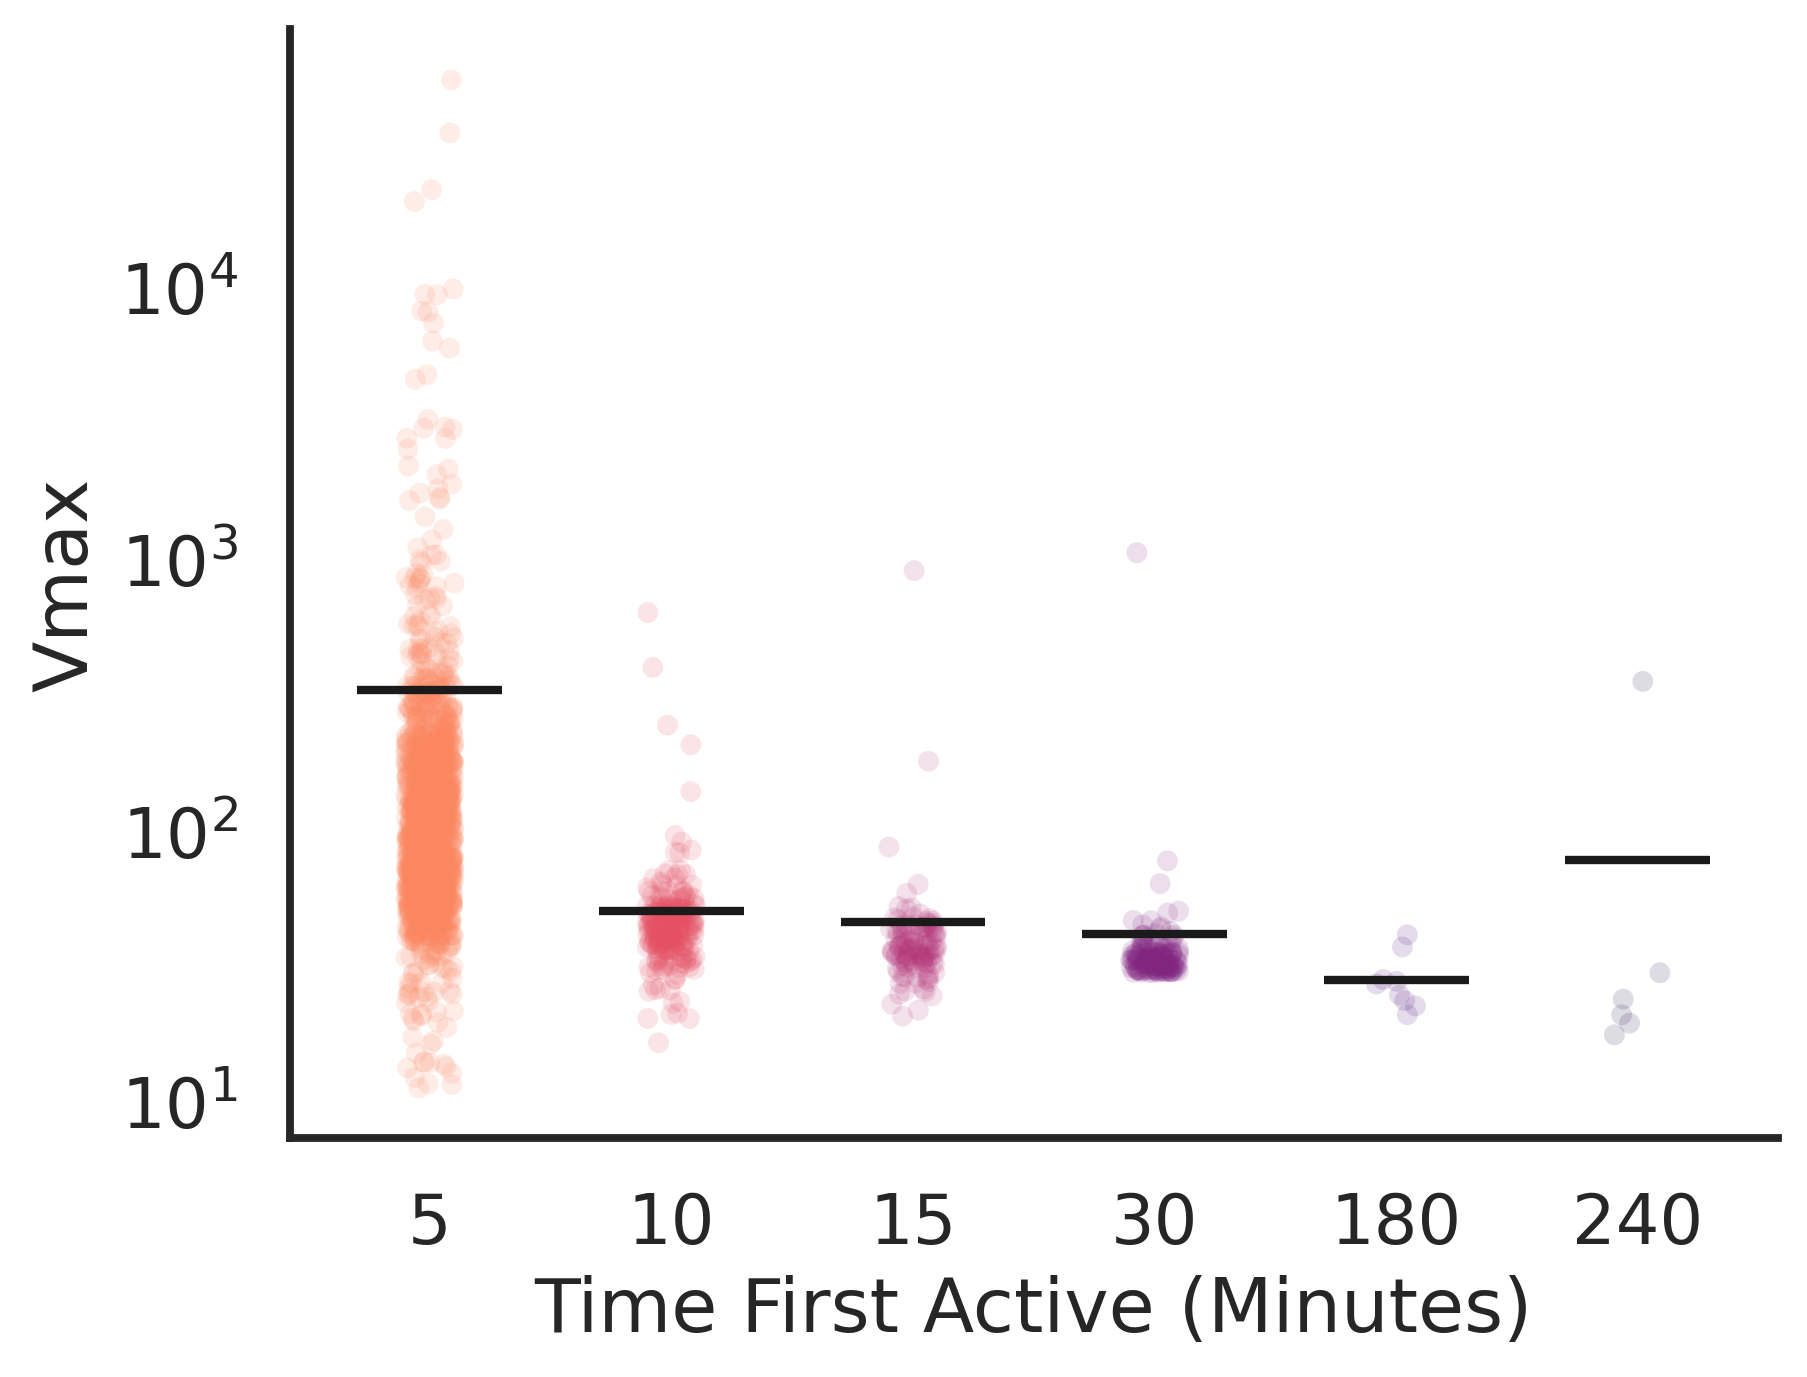

In [364]:
plt.figure(dpi = 300)
sns.set_context('talk')

# Define full order including 30
time_order = [0, 5, 10, 15, 30, 180, 240]

# Stripplot with explicit order
ax = sns.stripplot(
    data=final_means_cat_gcn4_active, 
    x="FirstExceed_gcn4", y="Vmax", 
    palette="magma_r", alpha=0.15,
    order=time_order
)

# Compute means per FirstExceed
mean_vmax = final_means_cat_gcn4_active.groupby("FirstExceed_gcn4")["Vmax"].mean()

# Plot horizontal lines at mean Vmax per group (skip if mean not available)
for i, t in enumerate(time_order):
    if t in mean_vmax:
        plt.hlines(y=mean_vmax[t], xmin=i-0.3, xmax=i+0.3, colors='k', lw=2, zorder = 10)

ax.set_yscale('log')

sns.despine()
plt.ylabel("Vmax")
plt.xlabel("Time First Active (Minutes)")
plt.show()

# 3. Distribution Shape [not working currently]

In [355]:
import pandas as pd
import seaborn as sns
sns.set_context('talk')
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.stats import norm


from scipy.stats import gaussian_kde
from sklearn.mixture import GaussianMixture

def fit_inactive_gaussian_to_all_data(df, active_threshold = 1, mu = False, sigma = False, title = False, supylabel_x = 0):
    # fig, axs = plt.subplots(4, 1,  figsize=(8, 4), dpi = 300)

    fig = plt.figure(dpi=300, figsize=(8, 6))

    # First three subplots share x-axis
    ax1 = plt.subplot(4, 1, 1)
    ax2 = plt.subplot(4, 1, 2, sharex=ax1)
    ax3 = plt.subplot(4, 1, 3, sharex=ax1)
    # Fourth one does not share x
    ax4 = plt.subplot(4, 1, 4)

    # Now you can access them as a list if needed
    axs = [ax1, ax2, ax3, ax4]
    
    # Optional: Hide x tick labels for the first two so they don't repeat
    # plt.setp(ax1.get_xticklabels(), visible=False)
    # plt.setp(ax2.get_xticklabels(), visible=False)
    # plt.setp(ax3.get_xticklabels(), visible=True)

    scores = np.array(df["score"]) 
    
    if mu == False and sigma == False:
        

        # # Make histogram to identify peak of density
        # hist, bin_edges = np.histogram(scores, bins=500)
        # bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        # # Find location of histogram peak
        # peak_index = np.argmax(hist)
        # peak_location = bin_centers[peak_index]

        # Estimate density using KDE fit to first 75% of data
        kde = gaussian_kde(scores[scores < np.percentile(scores, 95)])
        x_vals = np.linspace(min(scores), max(scores), 1000)
        kde_vals = kde(x_vals)

        # Find KDE peak location
        peak_index = np.argmax(kde_vals)
        peak_location = x_vals[peak_index]
        axs[2].axvline(peak_location, color = 'red', linestyle = 'dashed', lw = 1)
       
        # gmm = GaussianMixture(n_components=8).fit(scores.reshape(-1, 1))
        # peak_location = gmm.means_.min()

        # Use interval from 1st percentile of scores to histogram peak to determine threshold
        width_before_peak = peak_location - np.percentile(scores, 1)
        threshold = peak_location + np.abs(width_before_peak)

        # # Plot threshold
        sns.histplot(scores, bins = 500, ax = axs[0], stat = 'density', kde = True)
        axs[0].axvline(active_threshold)

        #sns.lineplot(x = x_vals, y = kde_vals, ax = ax0_twin, color = 'red')
        
        sns.histplot(scores, bins = 500, ax = axs[1], stat = 'density', kde = True)
        axs[1].axvline(peak_location, color = 'red', linestyle = 'dashed')
        #axs[0].axvspan(min(scores), np.percentile(scores, 1), color = 'gray', alpha = 0.5, lw = 0)
        axs[1].axvspan(threshold, max(scores), color = 'gray', alpha = 0.5, lw = 0)

        # Fit a gaussian to the inactive scores
        inactive_scores = scores[scores < threshold]
        mu, sigma = norm.fit(inactive_scores)

    # Plot the histogram and fitted Gaussian
    sns.histplot(scores, stat = 'density', bins = 500, ax=axs[2])
    x = np.linspace(min(scores), max(scores), 100)
    ax2 = axs[2].twinx()  # Update to use axs[1]
    ax2.plot(x, norm.pdf(x, mu, sigma), 'r-', label=f'Gaussian Fit\nμ={mu:.2f}, σ={sigma:.2f}', color = 'red')
    ax2.set_ylim(0, None)
    sns.despine()

    df["z-score"] = (df["score"] - mu) / sigma
    print(mu, sigma)
    print("New threshold:")
    new_threshold = (active_threshold - mu) / sigma
    print(new_threshold)

    sns.histplot(df["z-score"], bins = 500, ax = axs[3], stat = "density")
    axs[3].axvline(5, color = 'red')
    axs[3].axvline(new_threshold)

    fig.tight_layout(pad = 0)

    if title:
        plt.suptitle(title, va = 'bottom', y = 1.01)
        
    for ax in axs:
        ax.set_ylabel("")

    fig.supylabel("Density", x= supylabel_x)
    
    return df, new_threshold



In [356]:
# Define the time point columns
time_cols = ['0', '5', '10', '15', '30', '180', '240']

# Apply natural log (np.log) to these columns
final_means_cat_log = final_means_cat
final_means_cat_log[time_cols] = np.log(final_means_cat[time_cols])
final_means_cat_log
# If you prefer log10 instead:
# final_means_cat[time_cols] = np.log10(final_means_cat[time_cols])

Time,0,10,15,180,240,30,5,Vmax,Avg_StdDev,Activity
Tile,,,,,,,,,,
AAACAAAGAGCTACTCCATTGACTCCAGTTGTTCCAGAATCTGATGATCCAGTTGCTTTGAAGAGAGCTAGAAATACTGAAGCTGCTAGAAGATCTAGAGCTAGGAAATTGGAAAGAATG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.787659,0.431083,inactive
AAACAAAGATCTCAACCATTGCAACCAATTATTATTGATGATATTAAAGATGCTGCTGCTTTGAAGAGAGCTAAGAATACTGAAGCTGCTAGAAGATCTAGAGCTAGGAAGATGGAAAGA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.317024,0.356520,inactive
AAACAAATGTATATTGGTTCTAATAAACCATTGGGTAAAGATCATAGAGGTTATAATGCTCATAATTGGAAACAATGTGCTATTTACTTTCATATTAGATATCCAAATGTTTCTAATTGT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.621634,0.269212,inactive
AAACAACCAGATGTTGCTACTTGGGATGCTCATTCTAATAAAGGTCAATGTTTGTTAAATTCTGGTGGTTCTGCTAGACCATTGATTATTTGGTTGCCACATTCTCACTTTAAAGAATAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.984682,0.981397,inactive
AAACAAGATAAAGATGATGTTACTTCTGAAGTTGCTGATAGAAGATGTAAATCTACTTCTGATTCTCAAGATGTTTATGATAAACCAGGTGAATCTGAATCTCCAGAAAGAACTGAATAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.504457,0.396125,inactive
...,...,...,...,...,...,...,...,...,...,...
TTTGTTGATGGTTTGGATGCTGCTTCTTTGGCTATGTTTGATACTCAACAATTGGATAAAGTTCAAGCATTTGTTTCTGGTACTGTTTCTCCTAAAGATTTGCATGTTGATACTGCTCCA,NaN,-2.788269,-1.835813,-4.071982,NaN,-1.362671,NaN,38.055564,2.313608,active
TTTGTTGCTTCTCCAACATTTAATCATAAATTCTCTTCTTCTAATGCATTTACTACTGAACAAATGAAGACATTTGATCCAGAAGCTGCATTTAATGAATTGTTCTCTCCAGAGTTCTCT,NaN,-1.574650,-1.756090,-1.896723,-2.84378,-0.974169,-3.877963,73.708402,6.074092,active
TTTGTTGGTGATGGTGATTTGGATCAATCTTTGGCTGCTGATCCATGGTATCCATTGTTTCCAGAATCTGATAAATTGGATCAACCAACTAAAGTTGAACAATCTCCATTGATTATTGAT,NaN,NaN,-2.374598,-2.430768,NaN,-1.279767,NaN,42.340589,2.990464,active


Time,seq,score
0,AAACAAAGAGCTACTCCATTGACTCCAGTTGTTCCAGAATCTGATG...,NaN
1,AAACAAAGATCTCAACCATTGCAACCAATTATTATTGATGATATTA...,NaN
2,AAACAAATGTATATTGGTTCTAATAAACCATTGGGTAAAGATCATA...,NaN
3,AAACAACCAGATGTTGCTACTTGGGATGCTCATTCTAATAAAGGTC...,NaN
4,AAACAAGATAAAGATGATGTTACTTCTGAAGTTGCTGATAGAAGAT...,NaN
...,...,...
10929,TTTGTTGATGGTTTGGATGCTGCTTCTTTGGCTATGTTTGATACTC...,NaN
10930,TTTGTTGCTTCTCCAACATTTAATCATAAATTCTCTTCTTCTAATG...,NaN
10931,TTTGTTGGTGATGGTGATTTGGATCAATCTTTGGCTGCTGATCCAT...,NaN
10932,TTTGTTGTTTCTAGATCTCCAGCTGCTGTTCATATTGCTTGTTGTA...,NaN


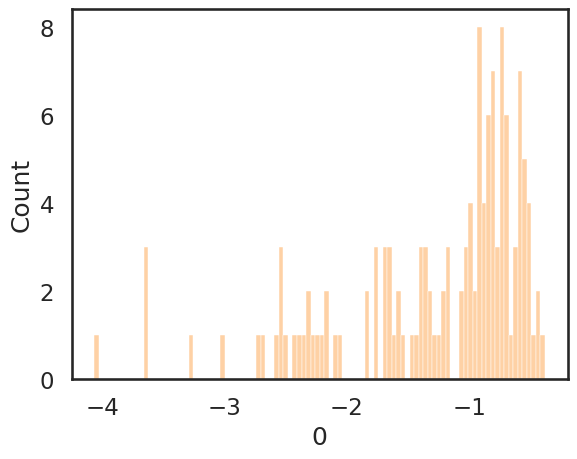

In [357]:
one_time_pt = final_means_cat_log[["0"]]
one_time_pt = one_time_pt.reset_index()
one_time_pt = one_time_pt.rename(columns = {"Tile" : "seq", "0" : 'score'})
sns.histplot(final_means_cat_log["0"], bins = 100)
one_time_pt

-1.2835718915189513 0.7792316701713486
New threshold:
2.9305429680711086


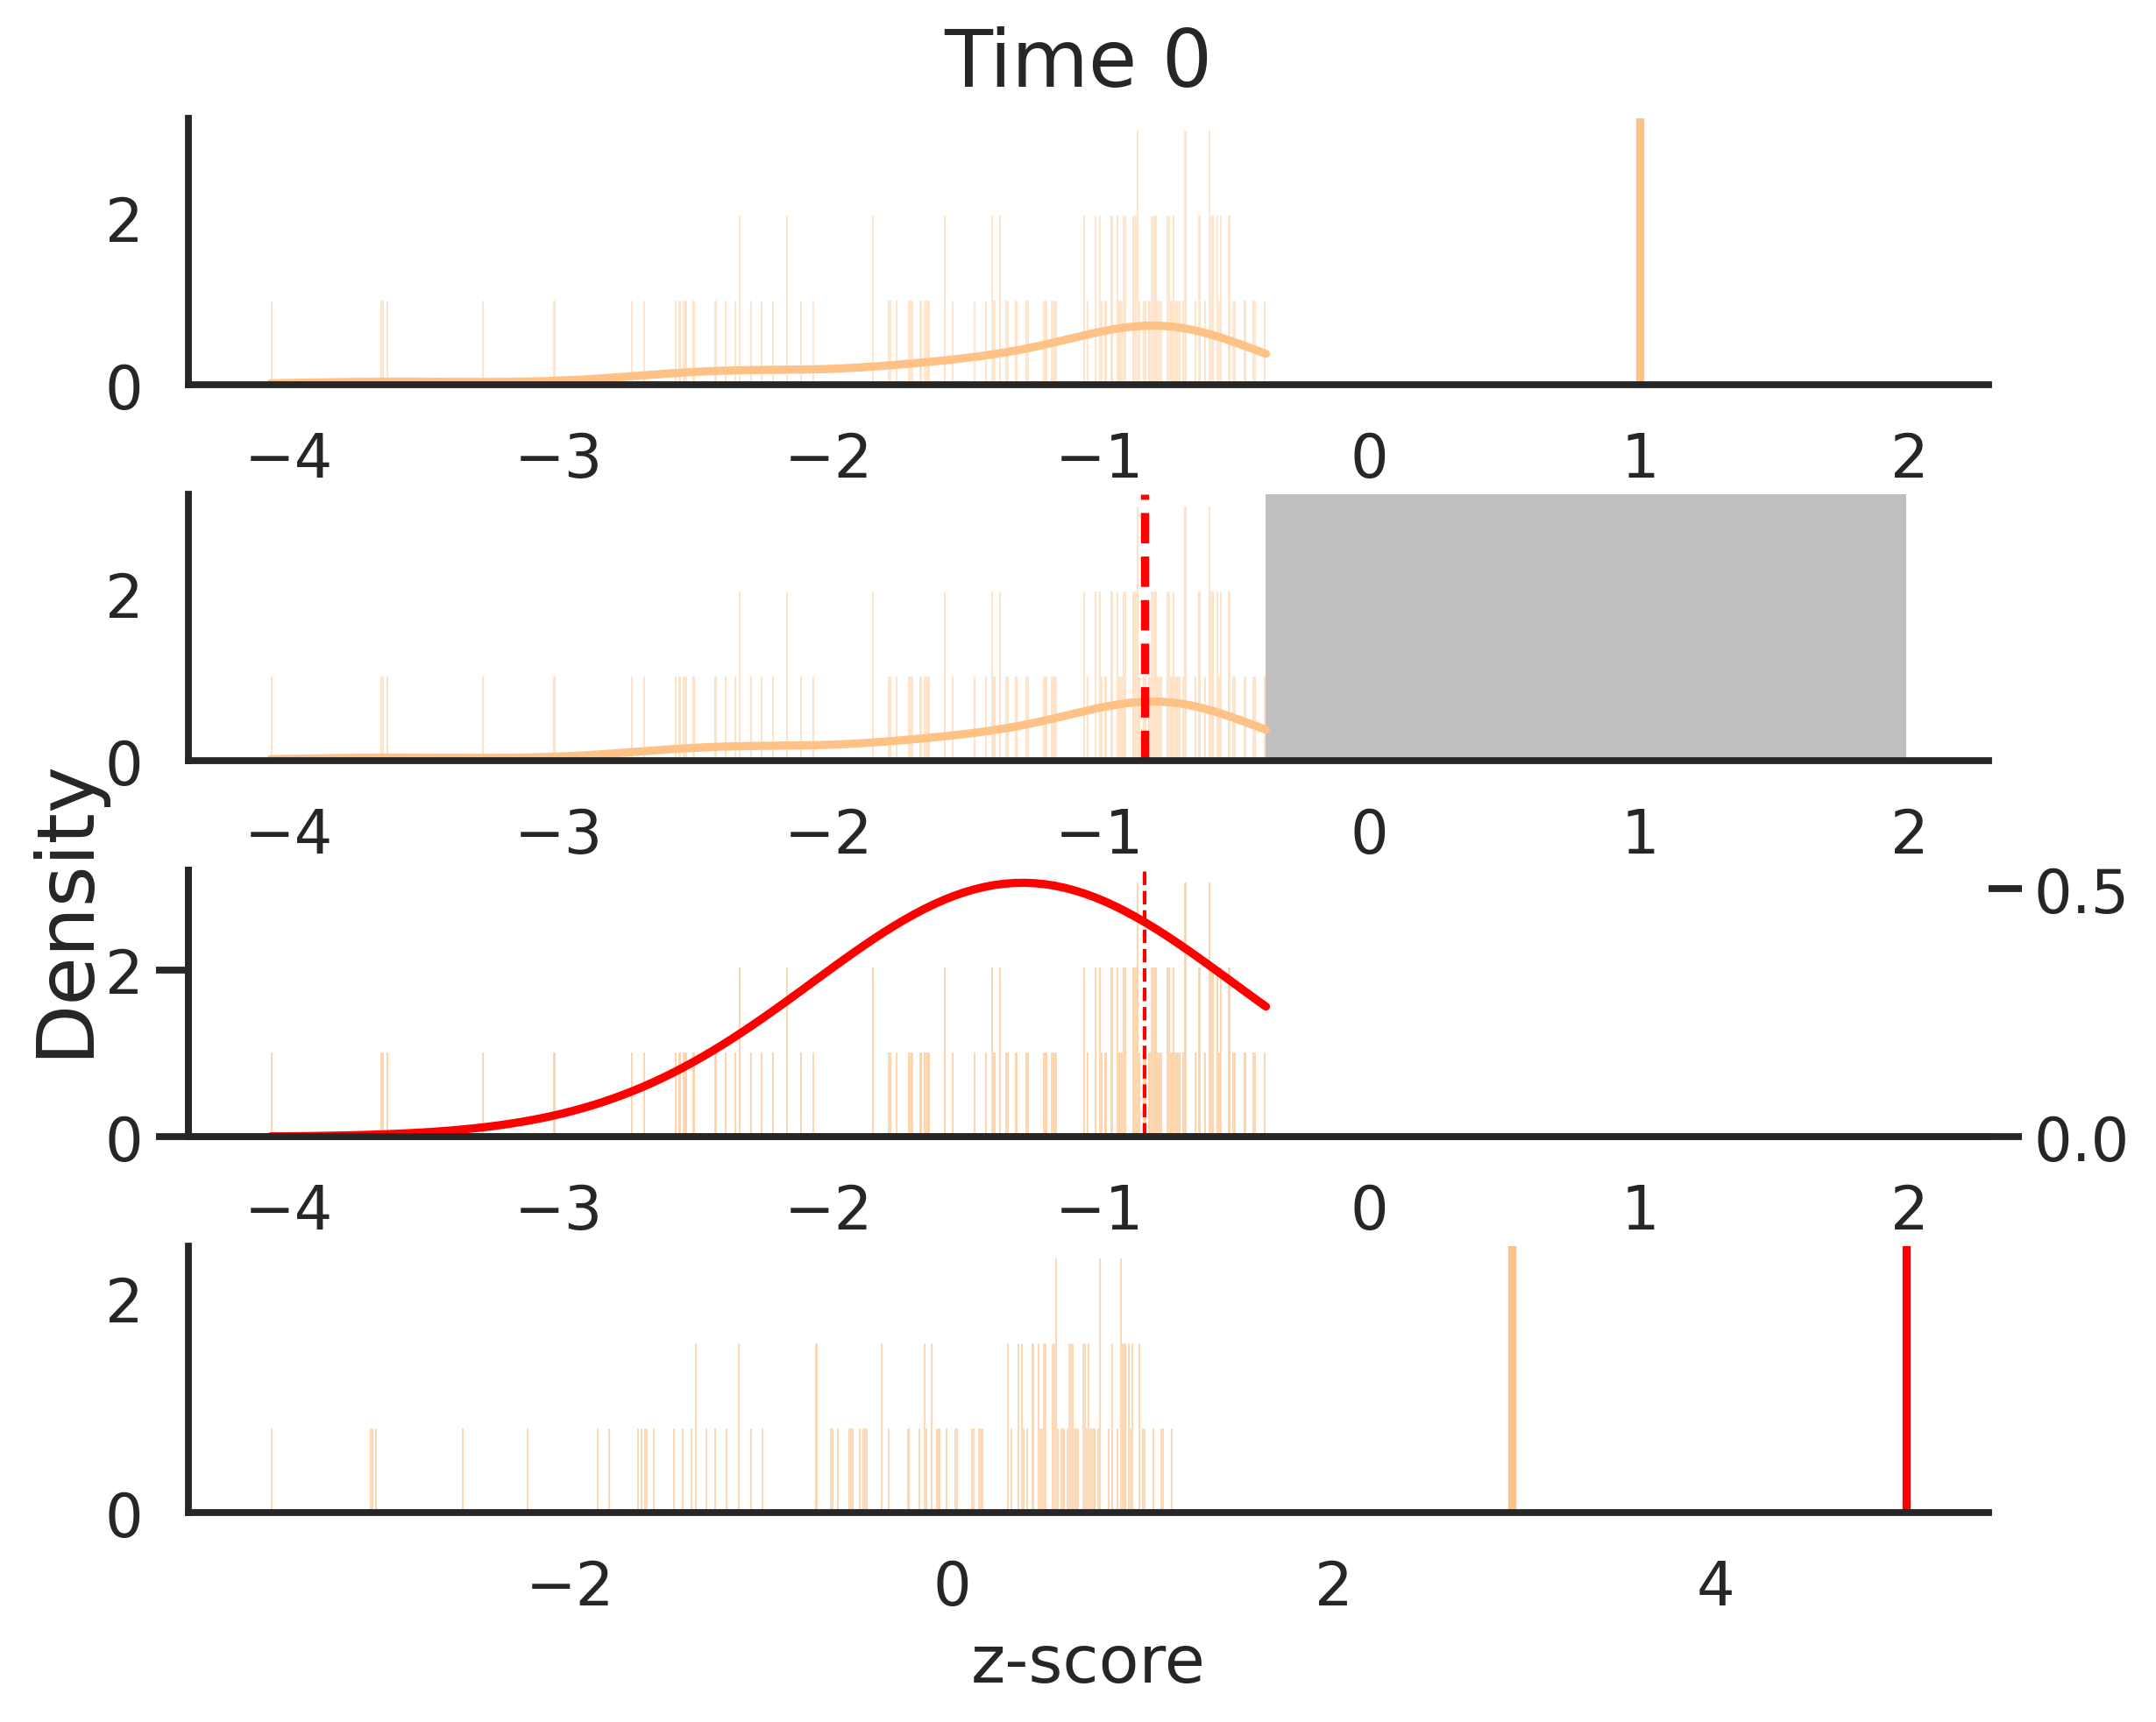

-1.8283156512633048 1.0013998453459871
New threshold:
2.824361981288415


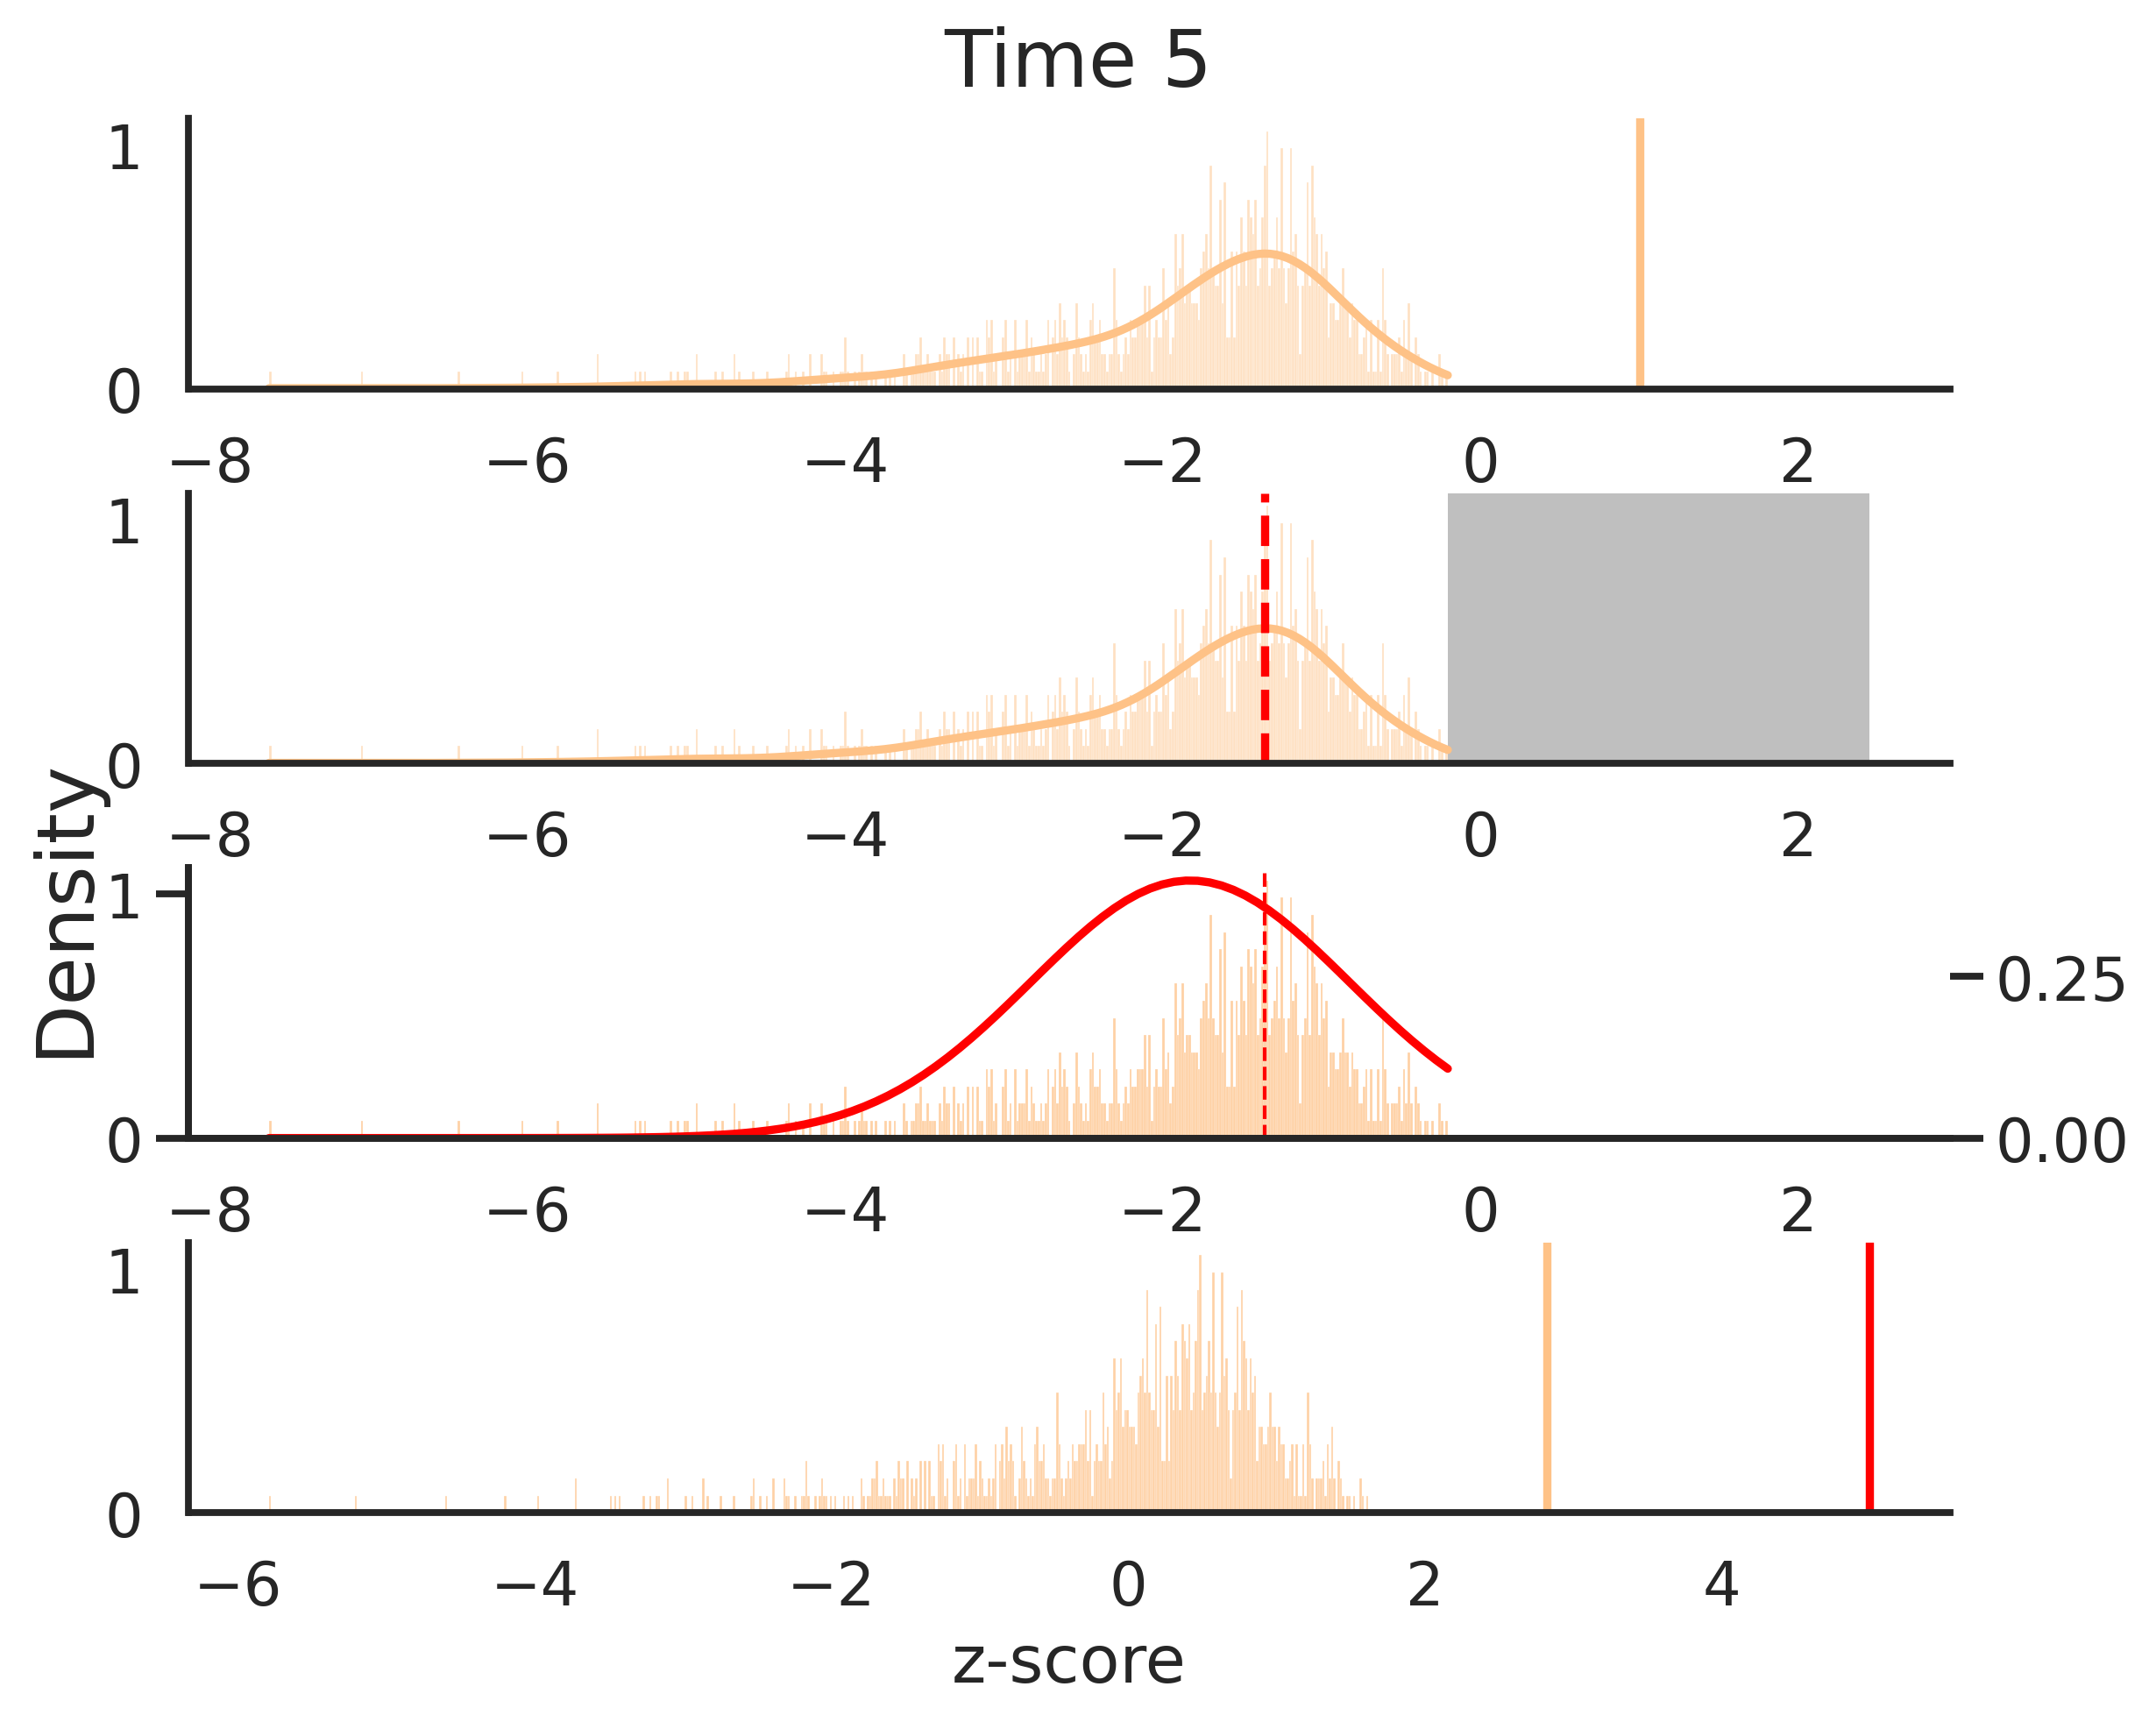

-1.6988037264438889 1.006494151037385
New threshold:
2.681390372375492


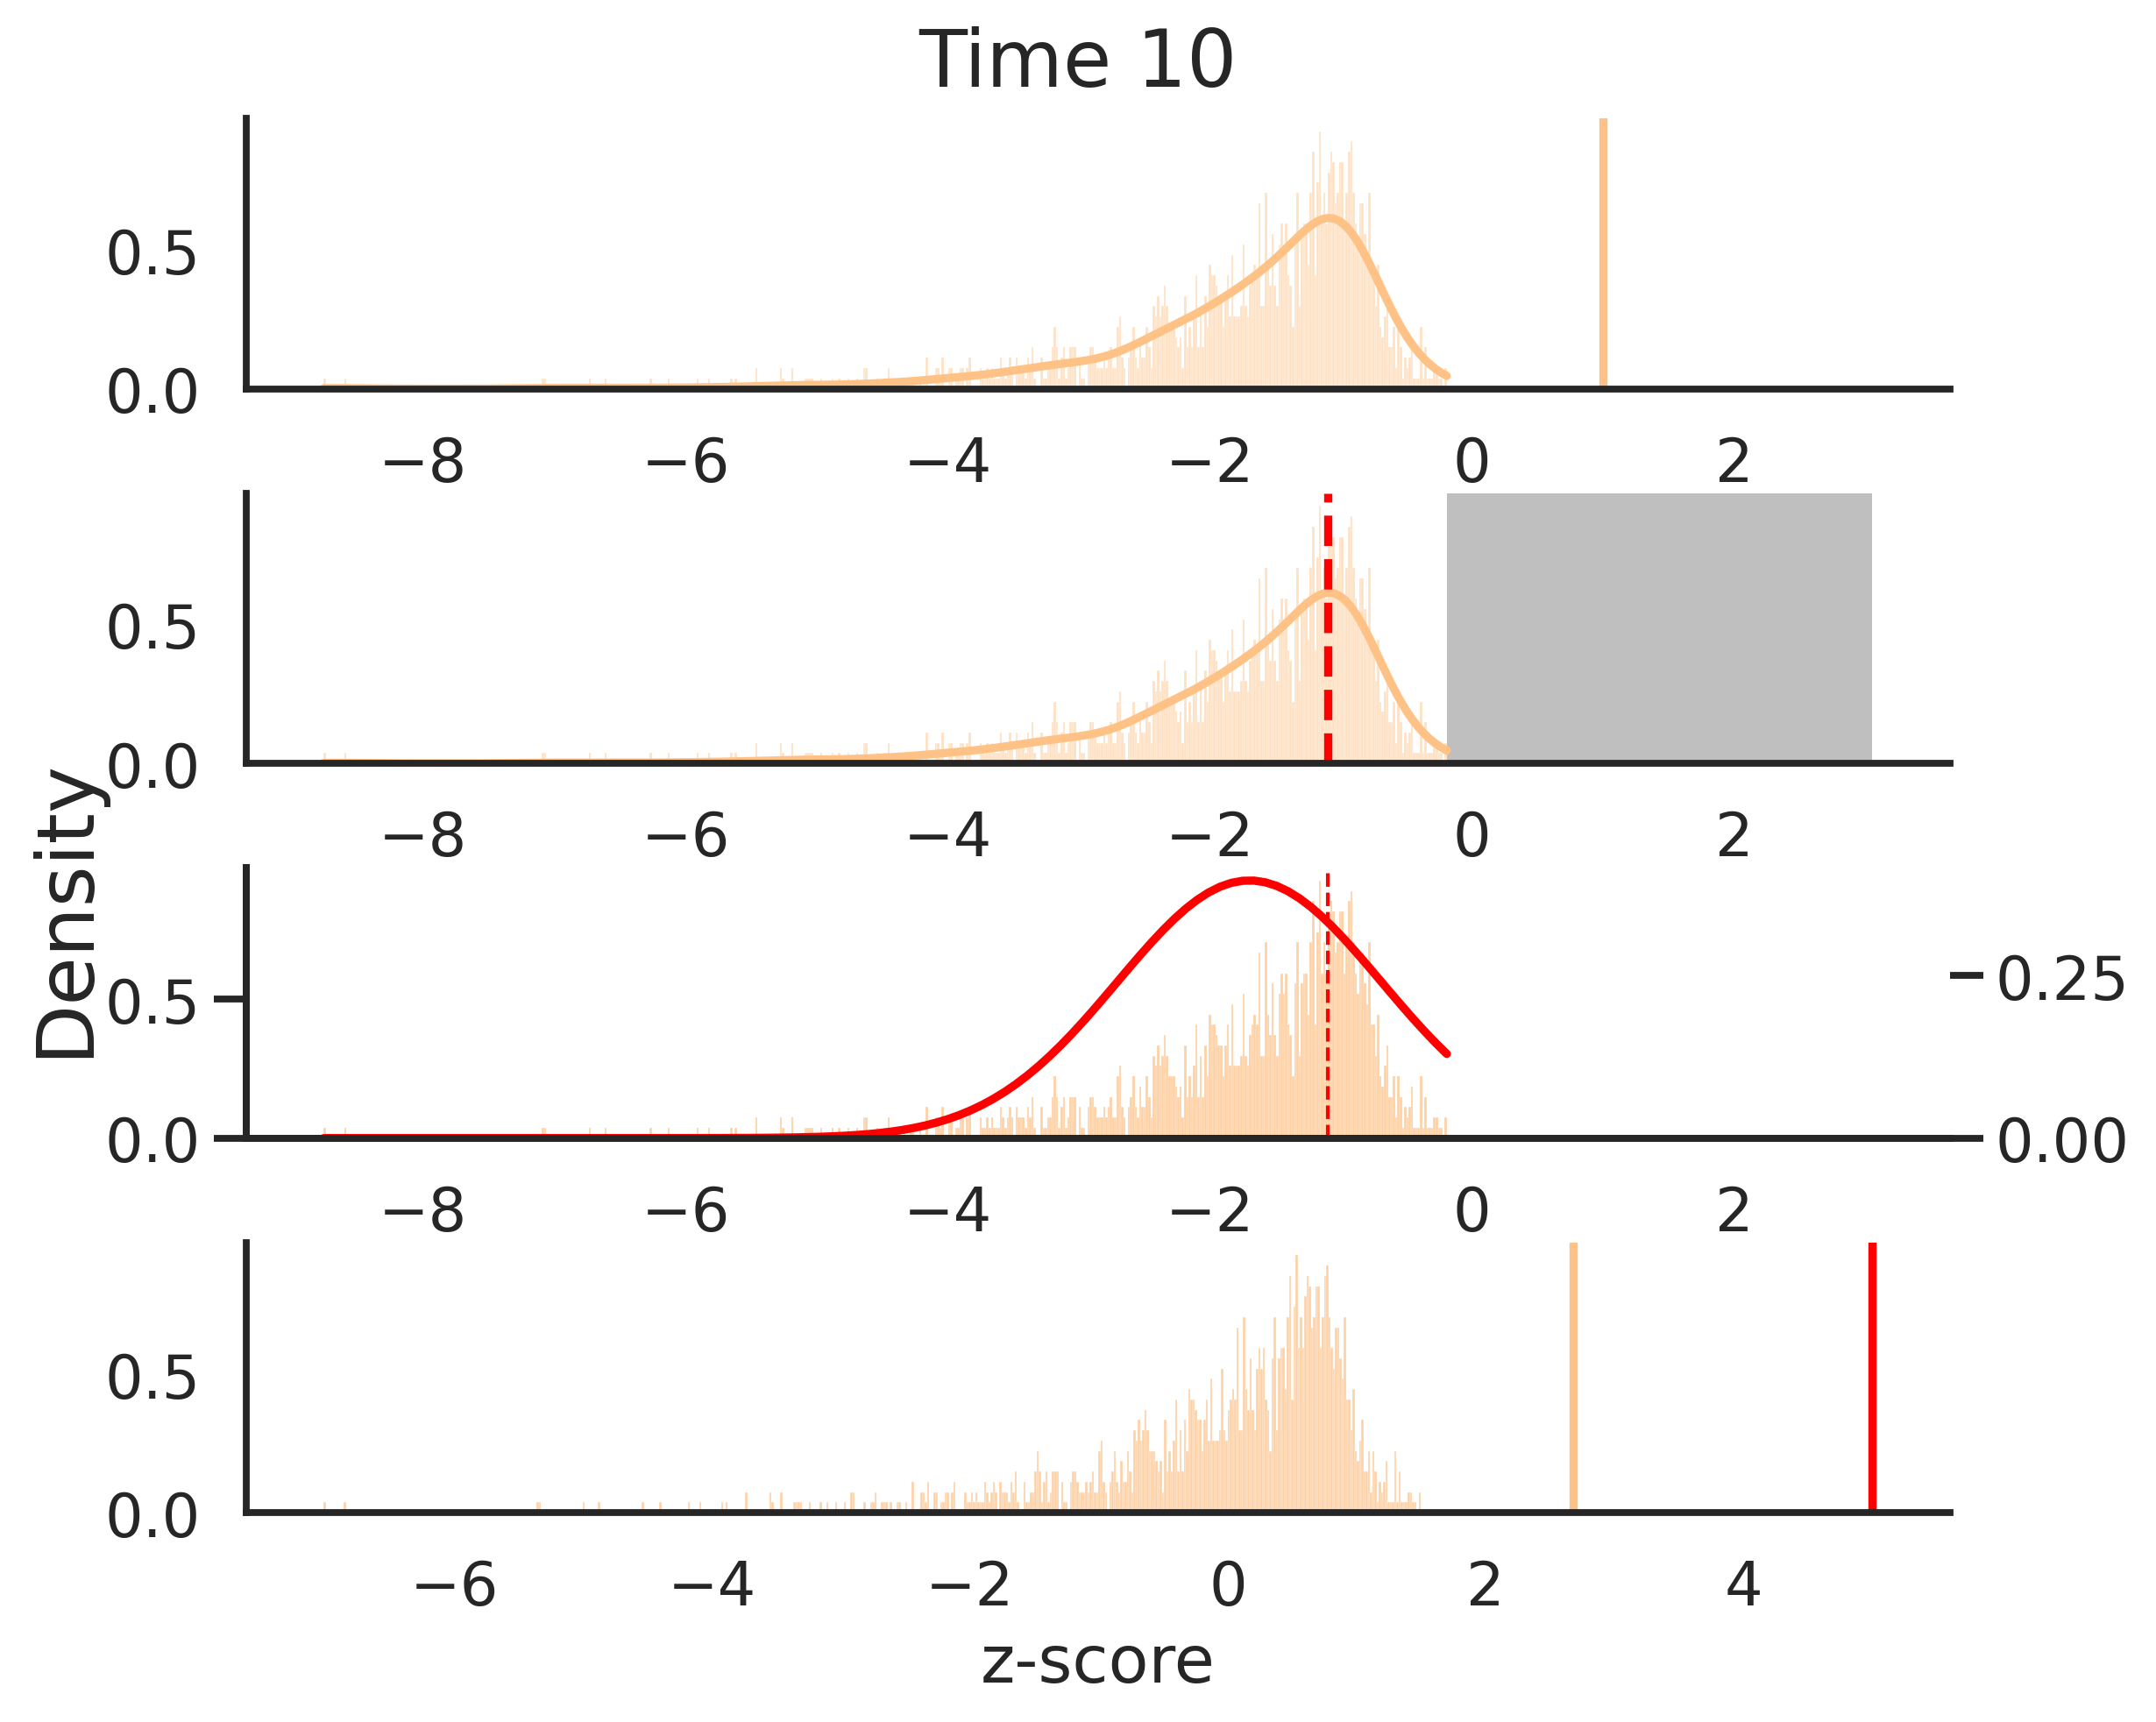

-1.6330931950605536 0.9930809950311154
New threshold:
2.651438511294895


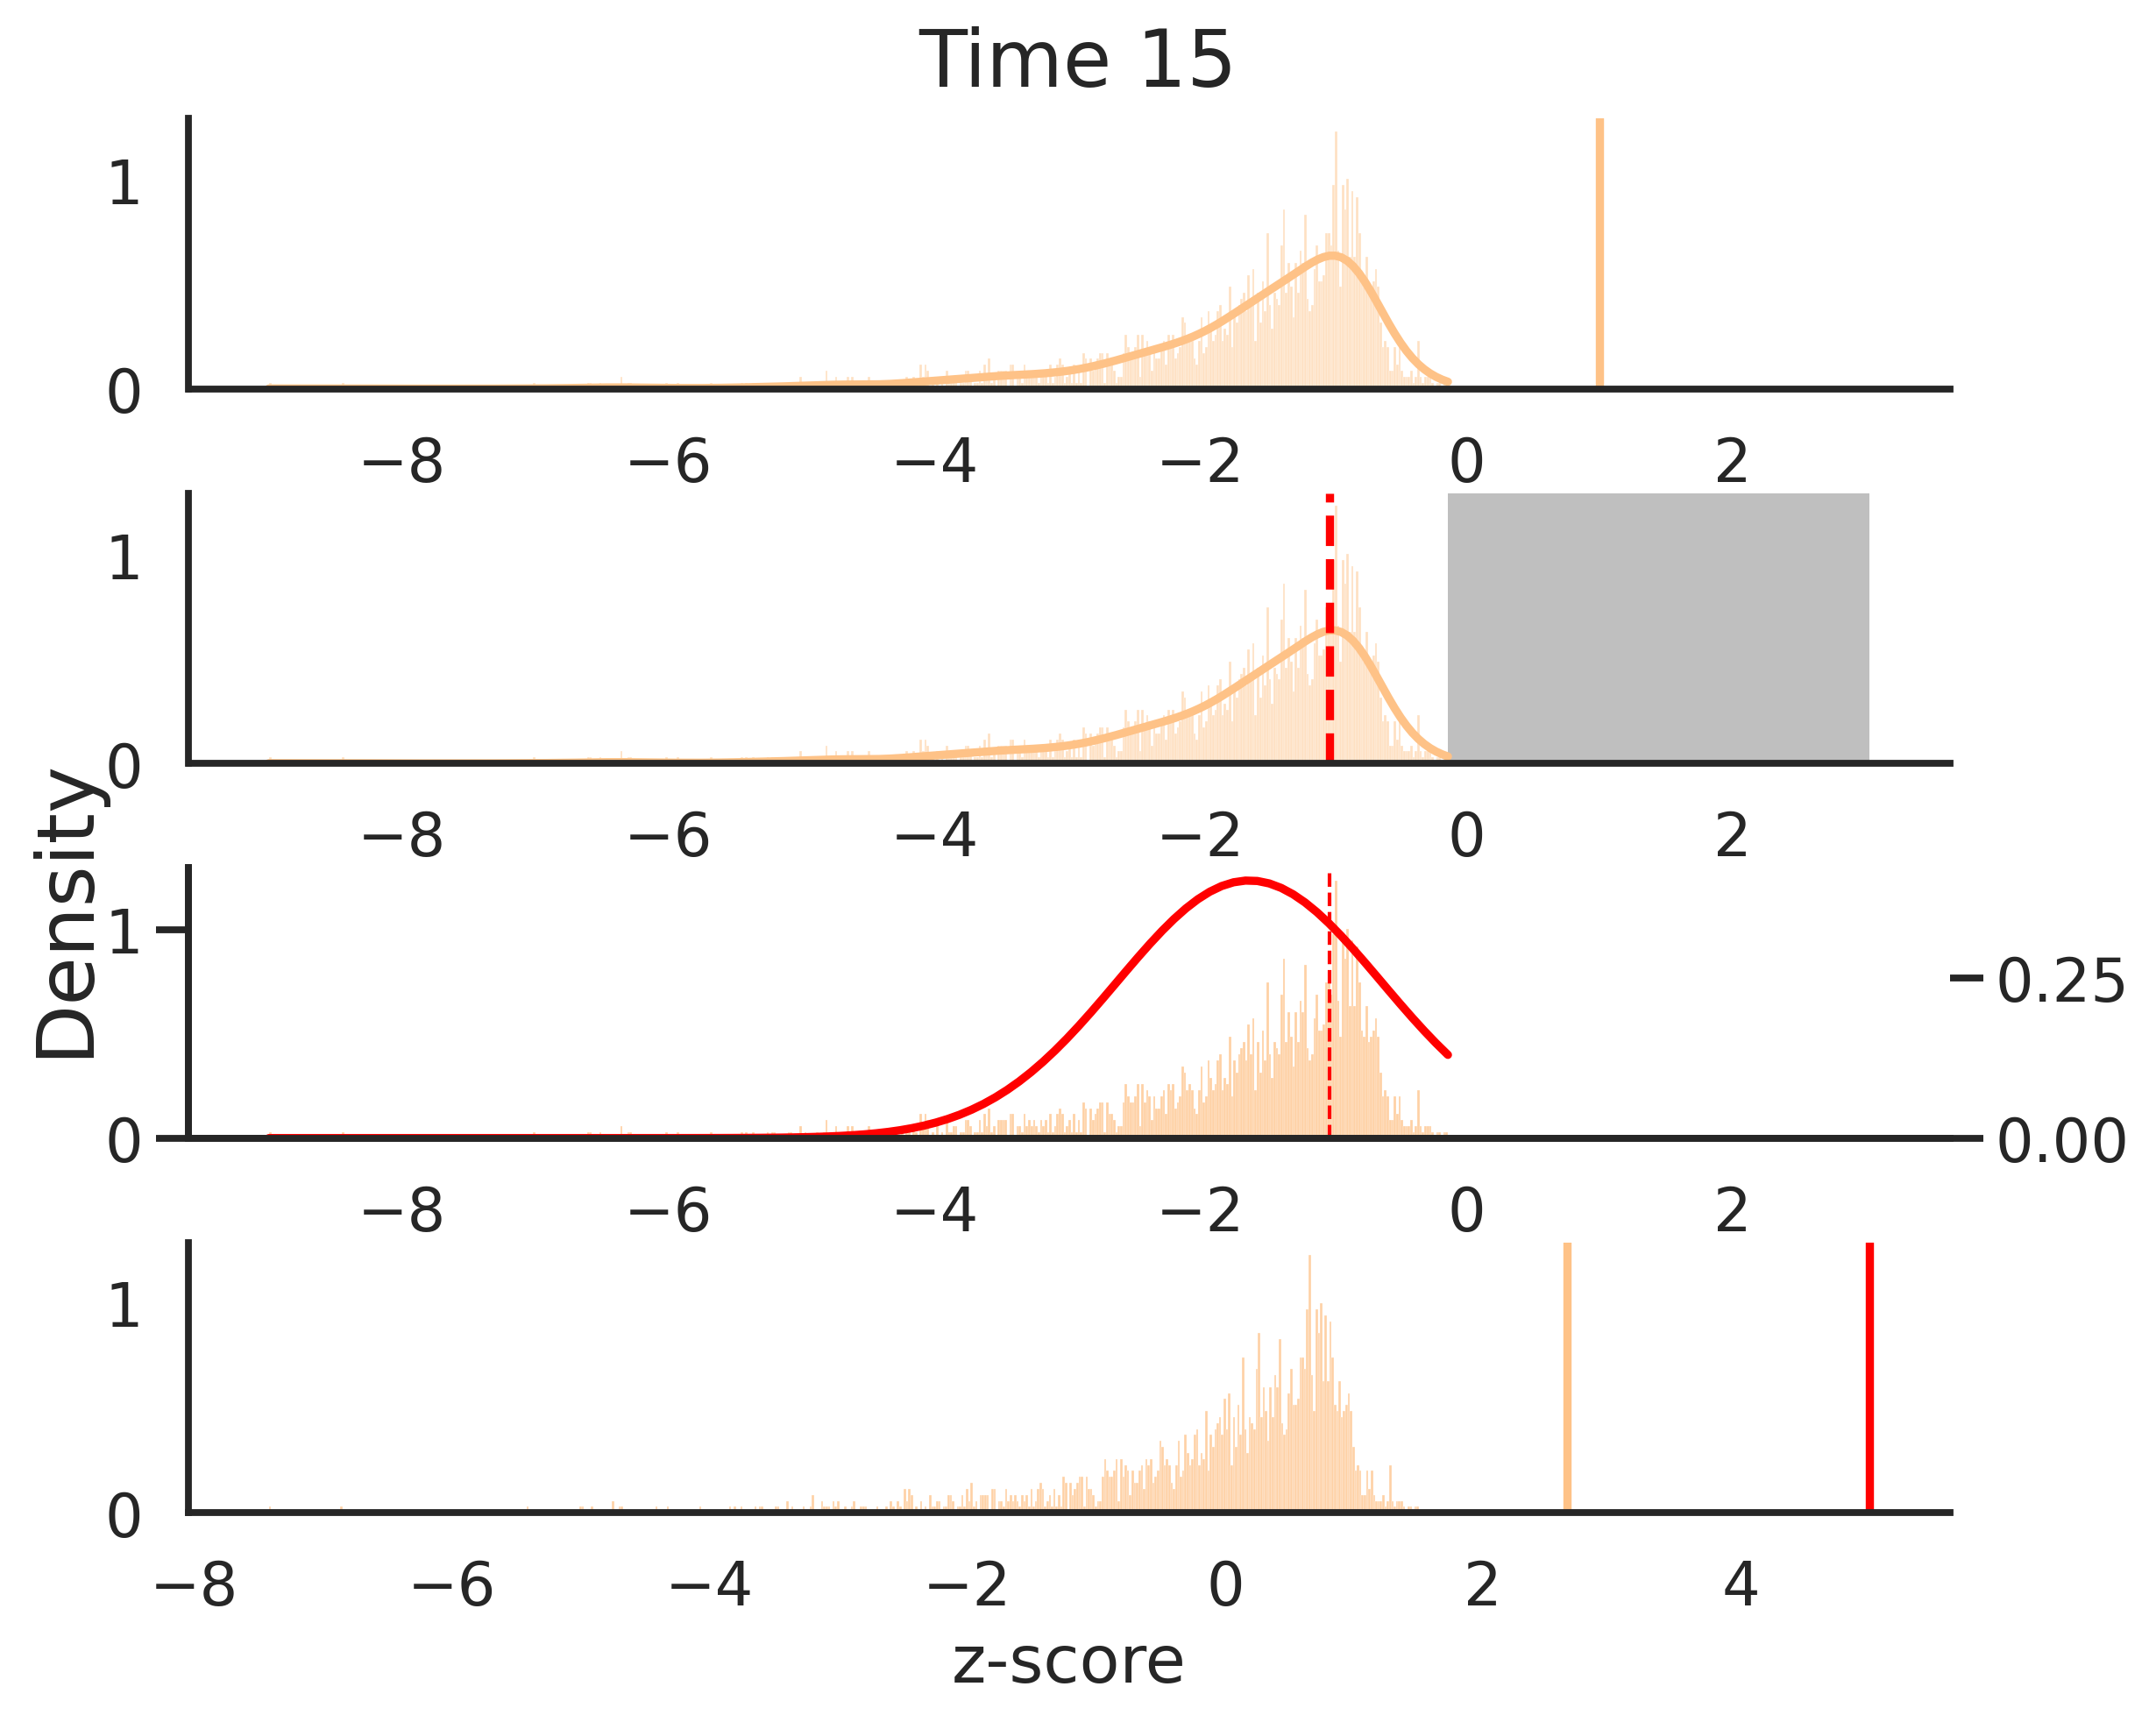

-1.469790309161273 0.9107113017623062
New threshold:
2.7119354996276126


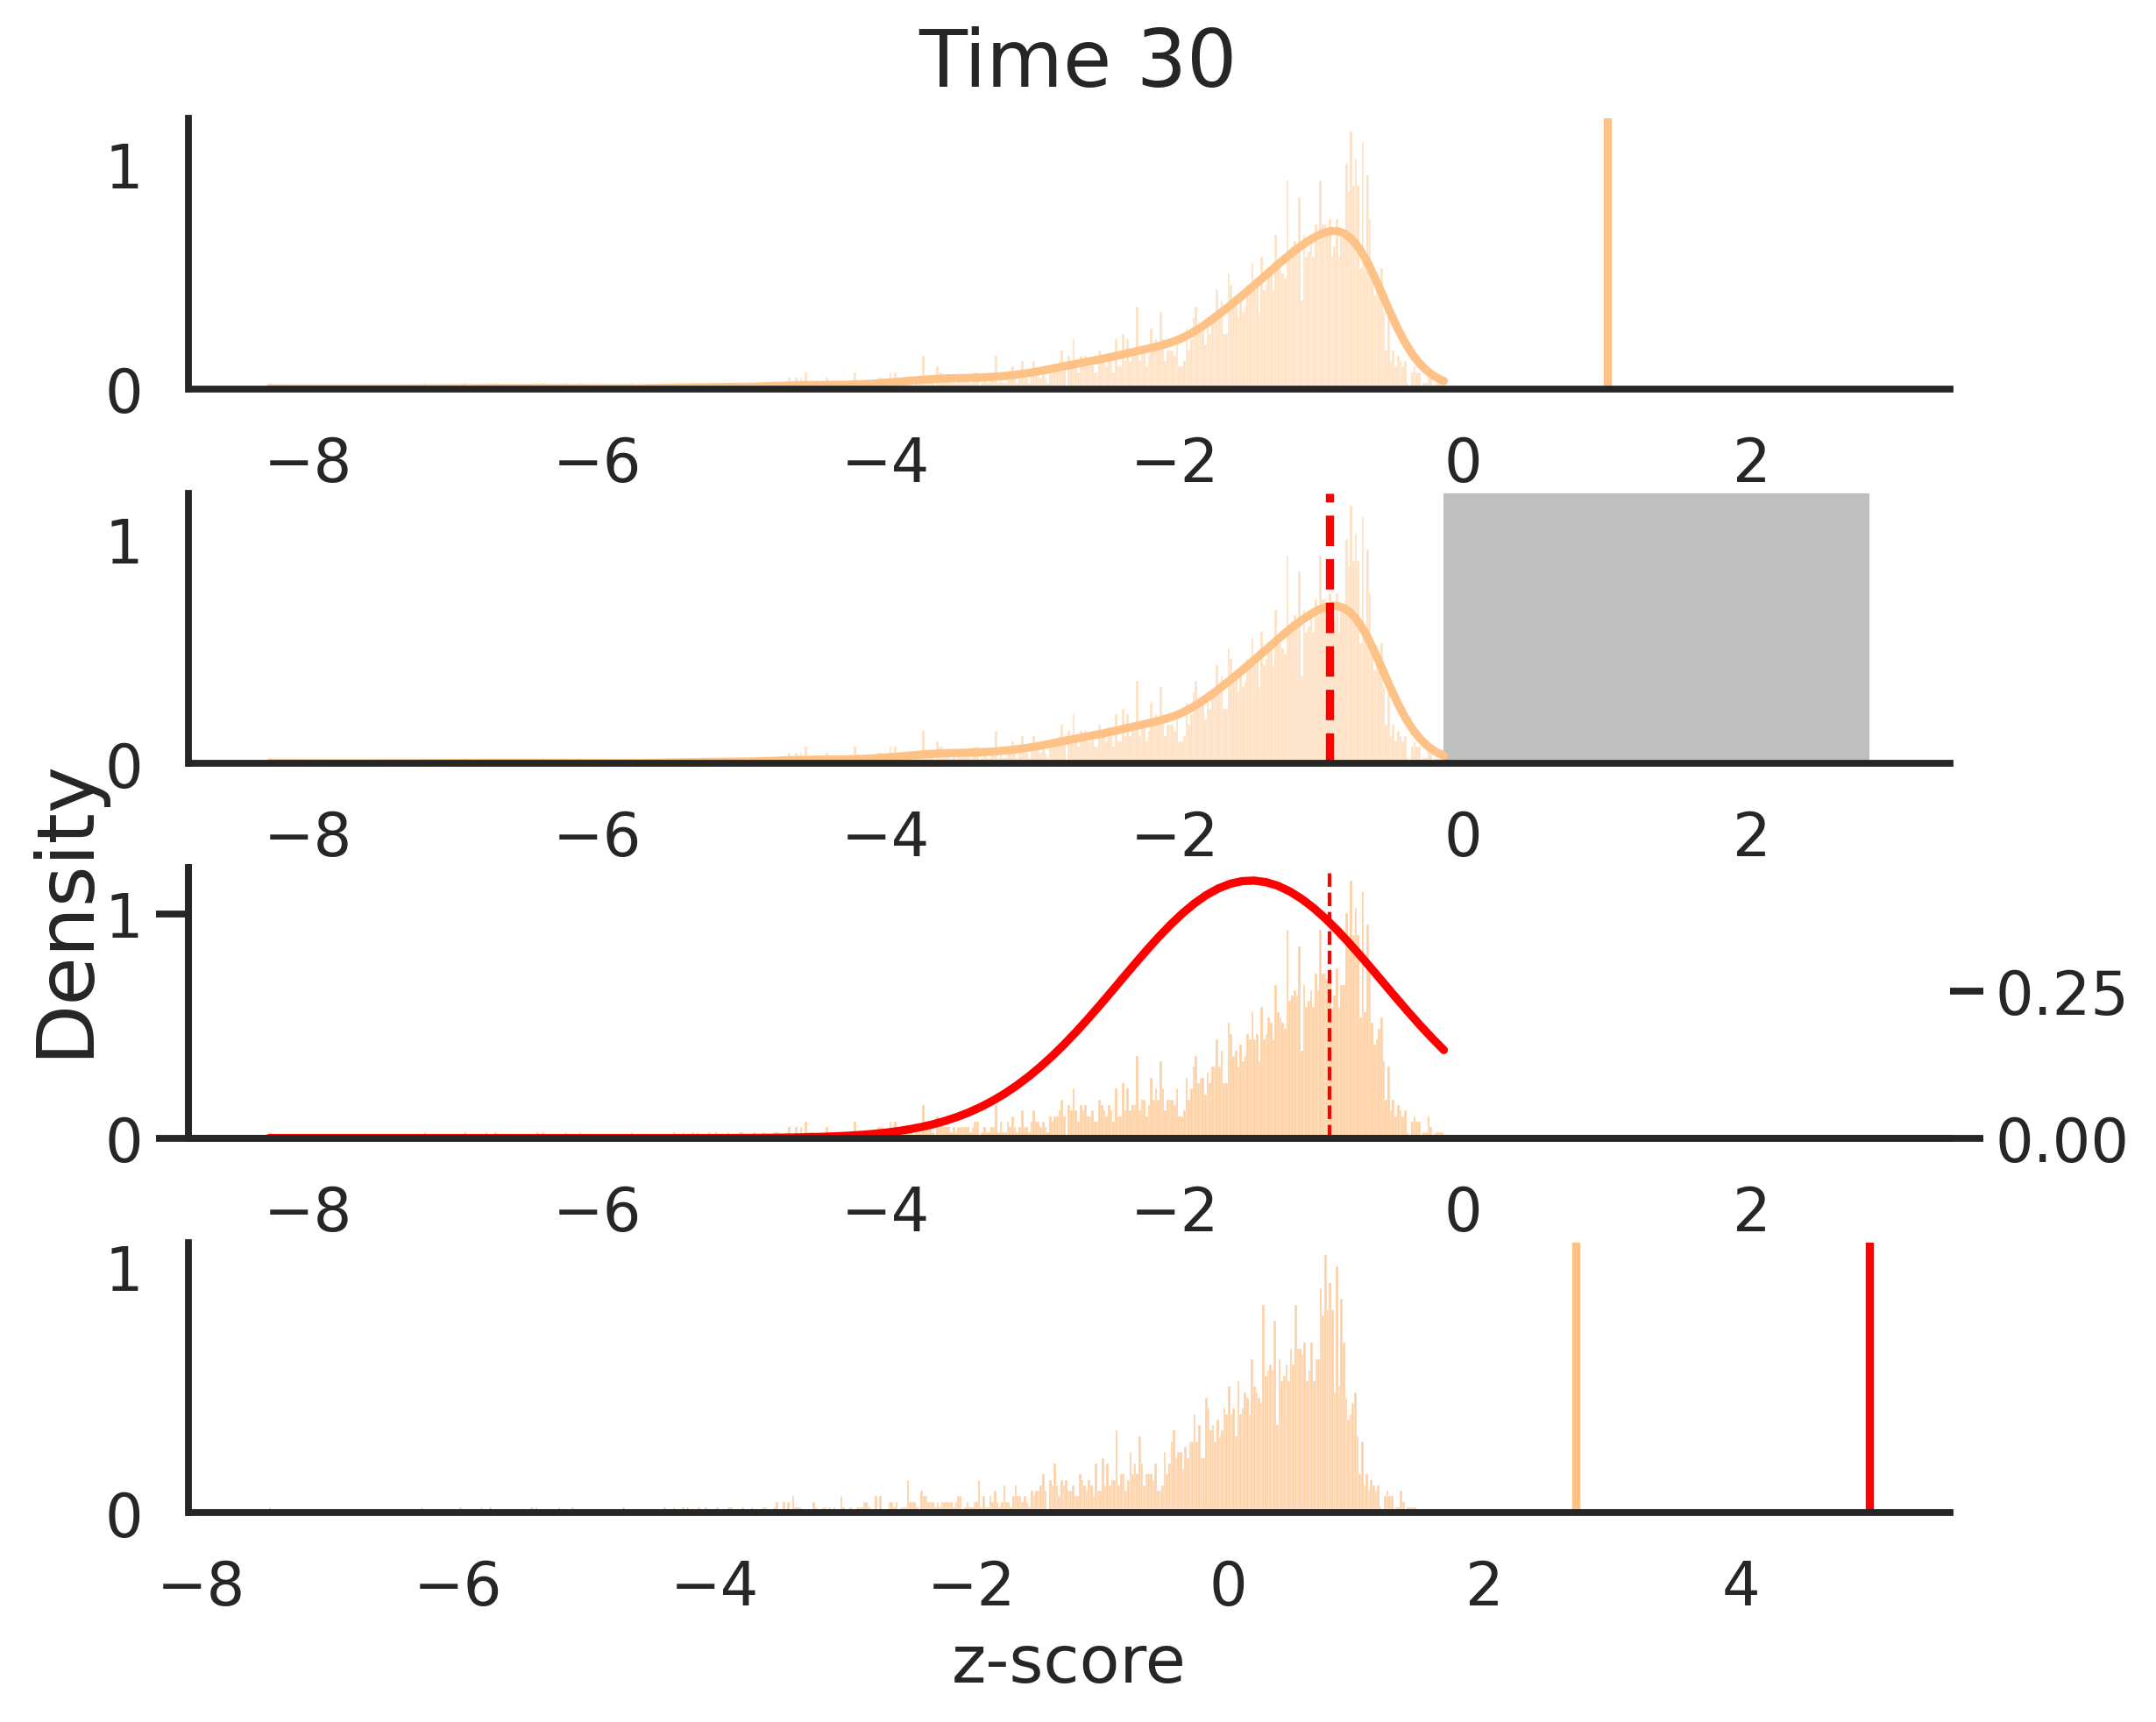

-2.0255356899597765 1.0975166456363523
New threshold:
2.756710526431731


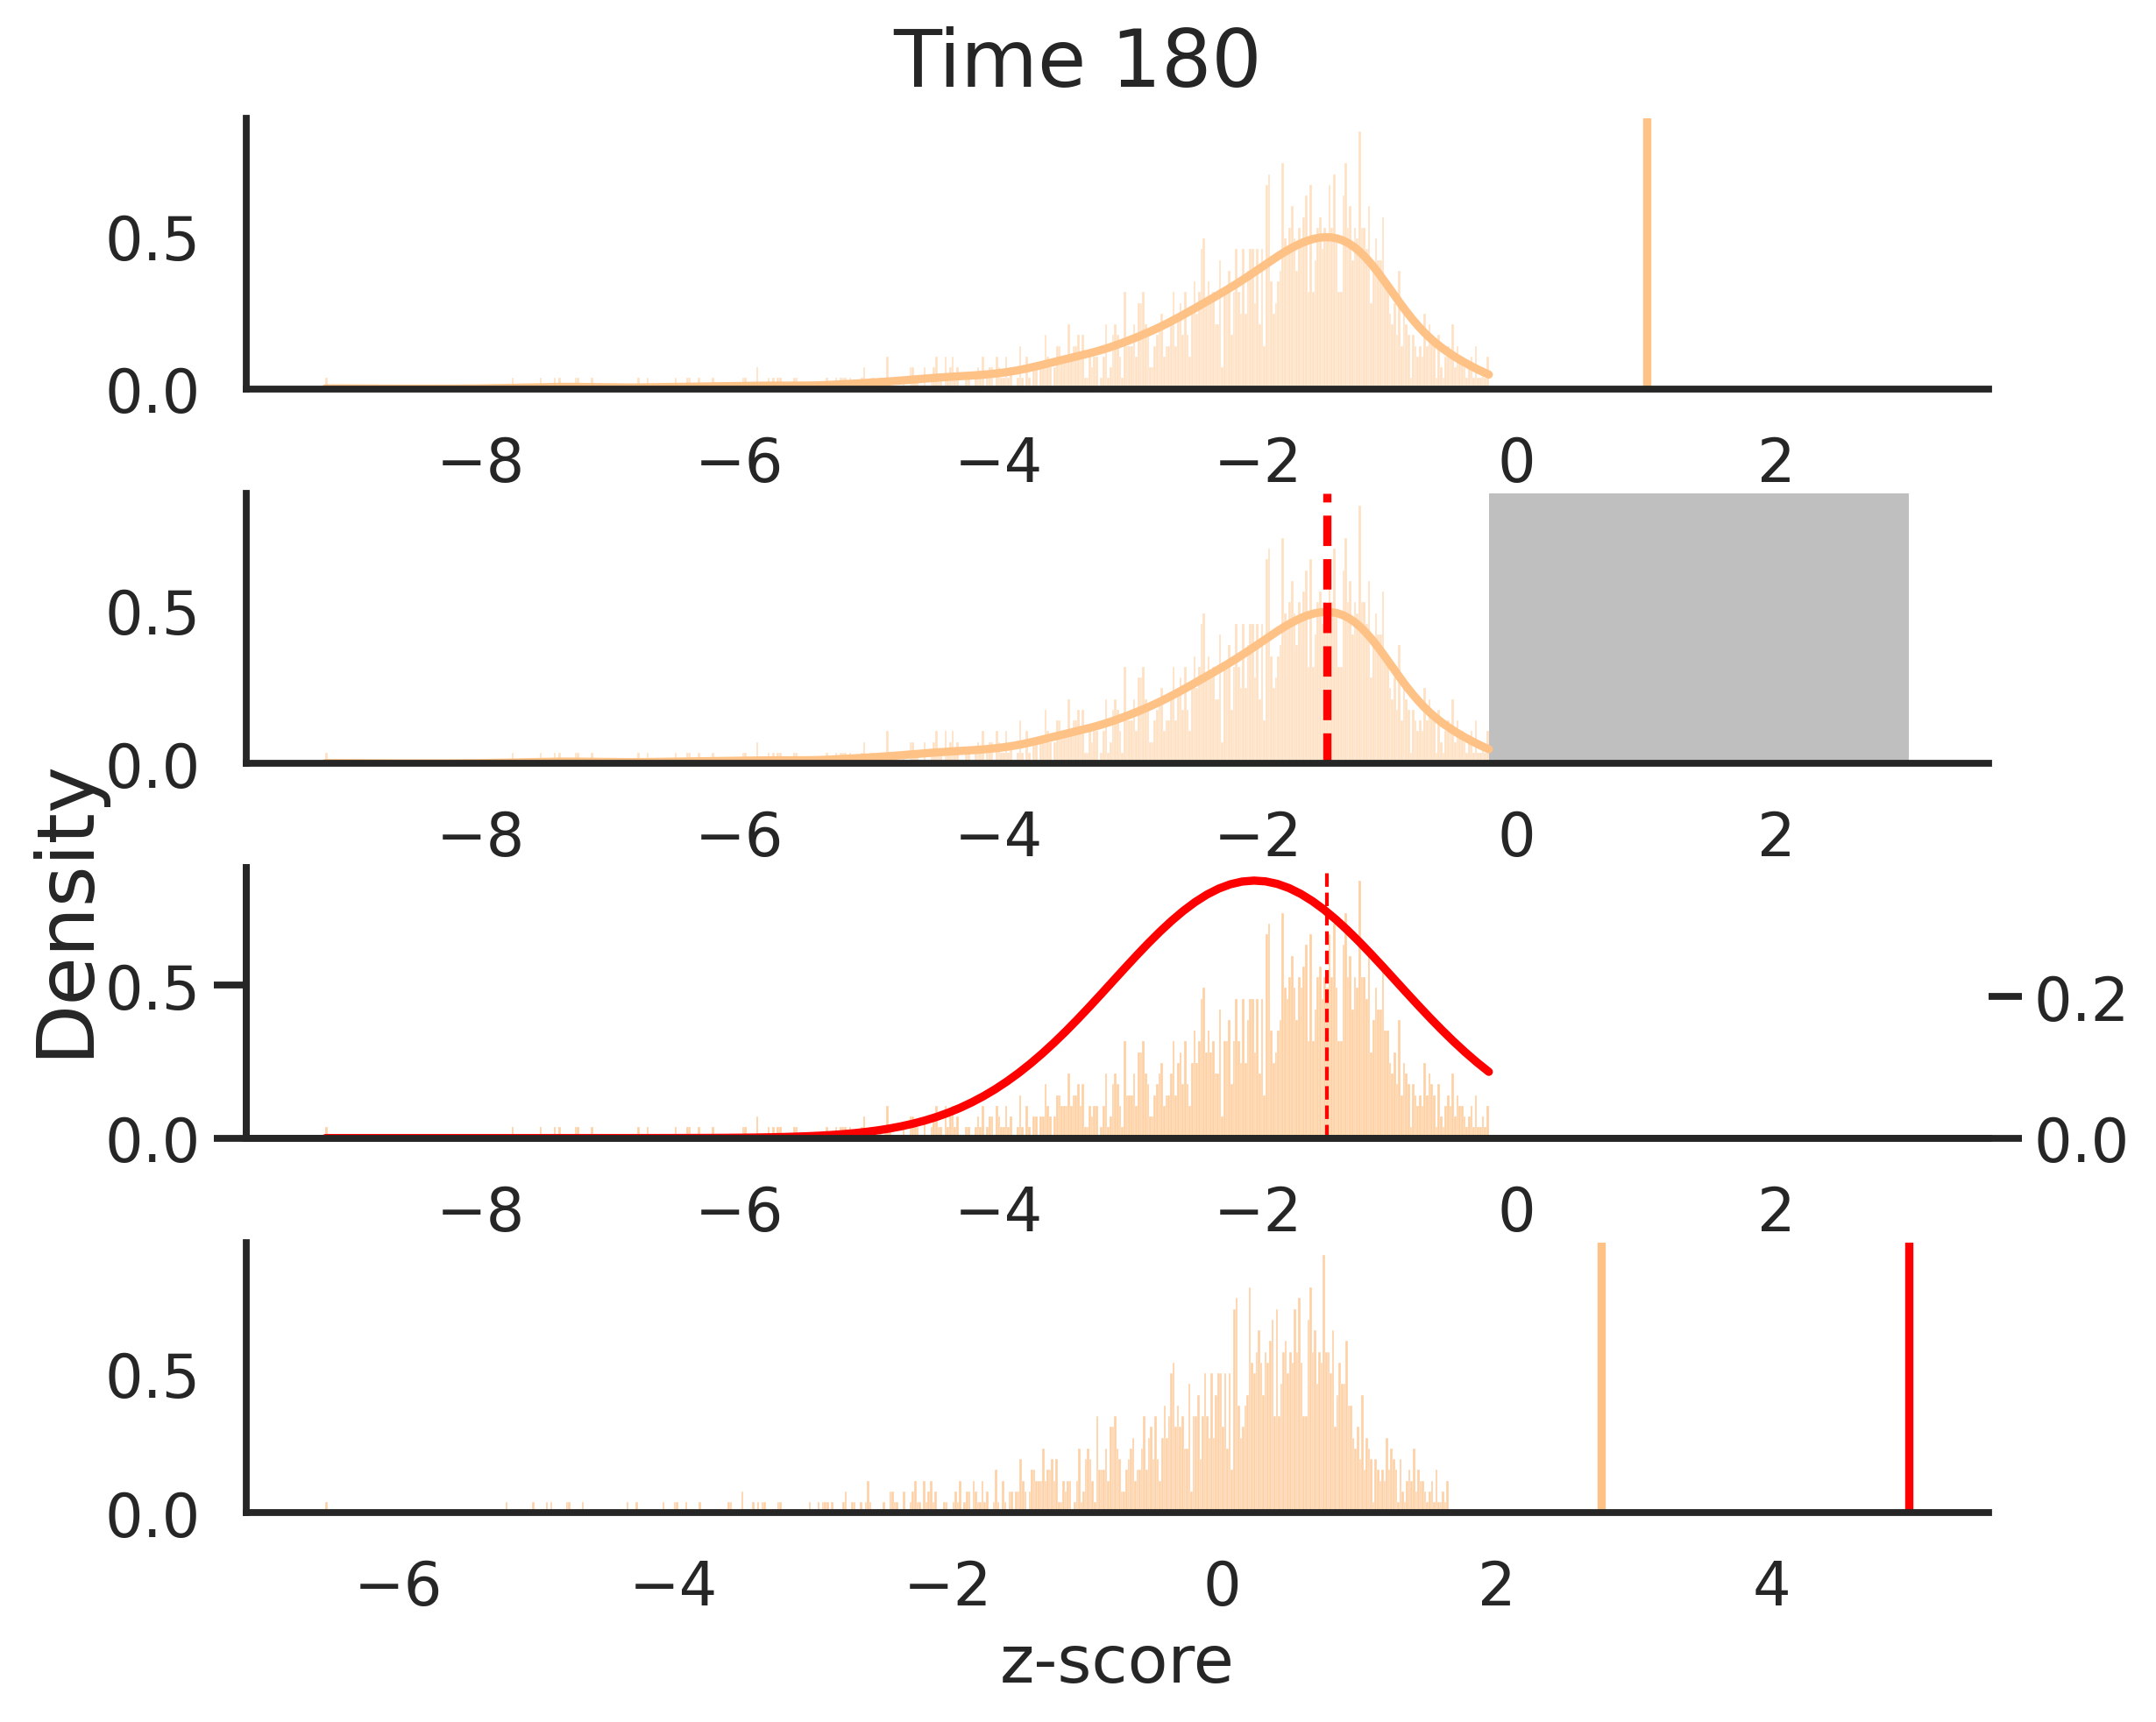

-2.1768058045136627 1.1543537806779463
New threshold:
2.7520209641865083


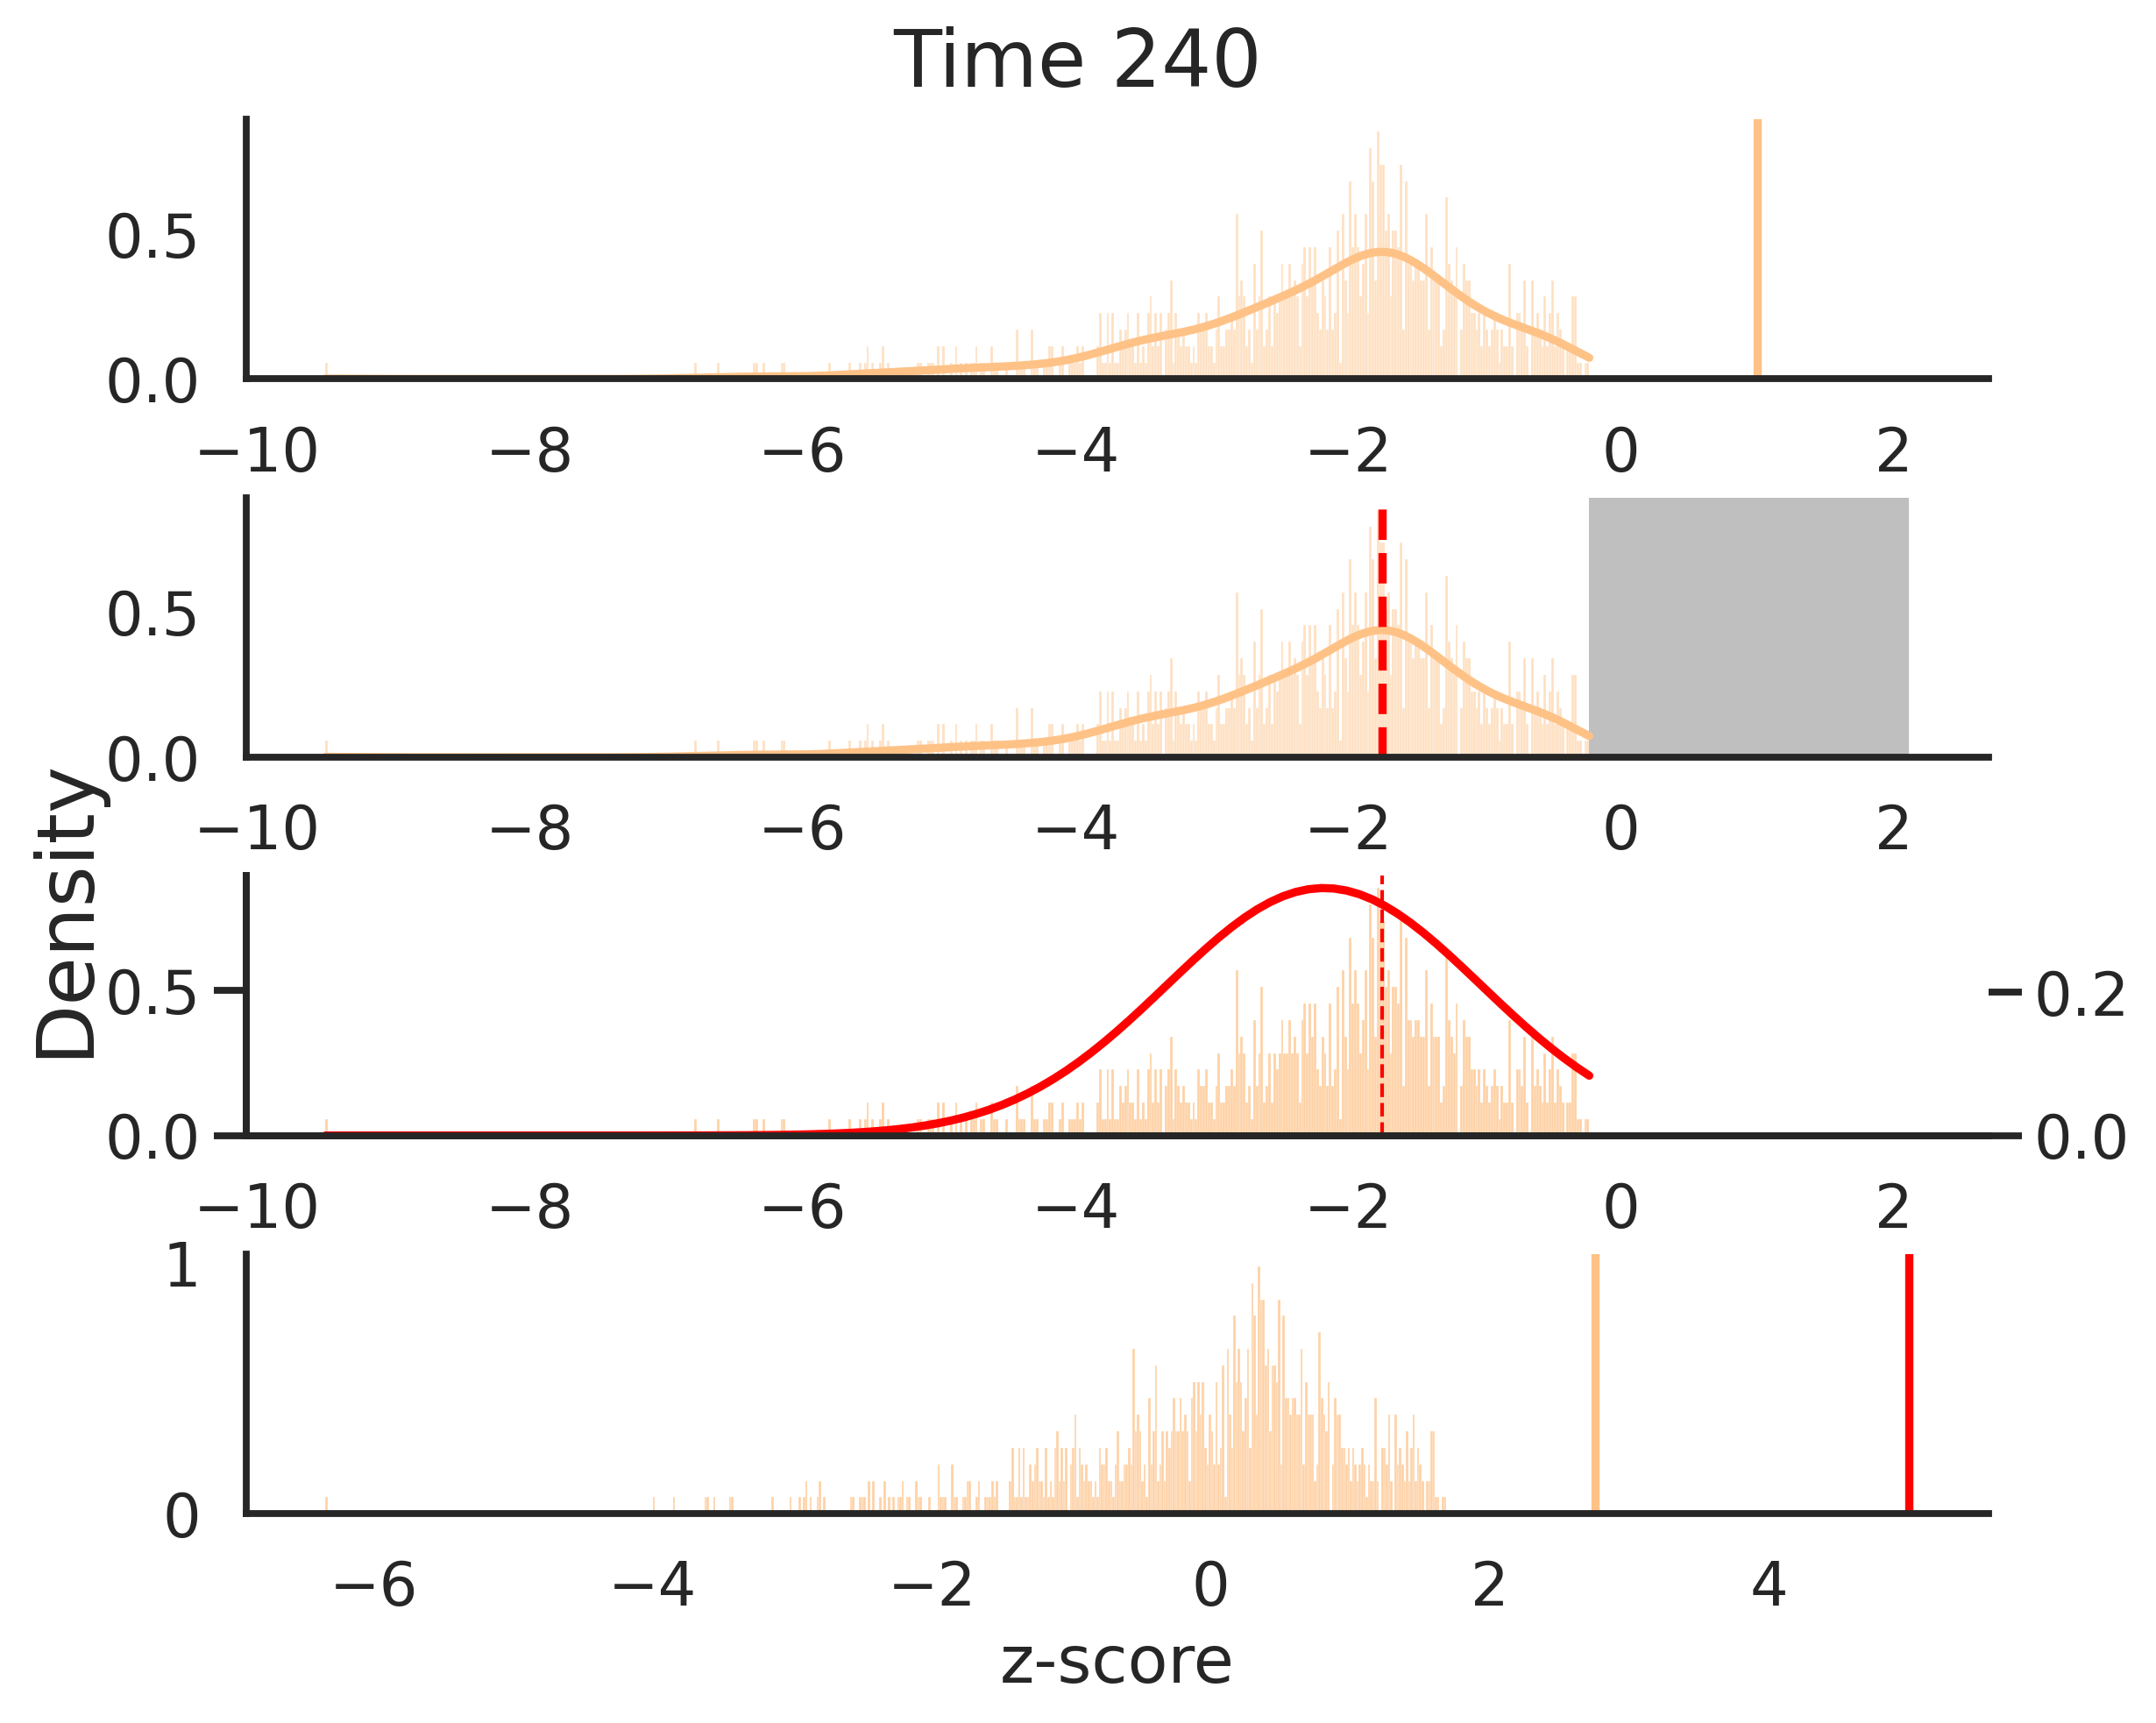

{'0': 2.9305429680711086, '5': 2.824361981288415, '10': 2.681390372375492, '15': 2.651438511294895, '30': 2.7119354996276126, '180': 2.756710526431731, '240': 2.7520209641865083}


In [359]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# Define your time points
time_points = ['0', '5', '10', '15', '30', '180', '240']

# Dictionary to save thresholds
thresholds = {}

for t in time_points:
    # Select data for this time point
    one_time_pt = final_means_cat_log[[t]].copy()
    one_time_pt = one_time_pt.reset_index()  # moves 'Tile' from index to column
    one_time_pt = one_time_pt.rename(columns={"index": "seq", t: 'score'})  # rename index to seq
    one_time_pt = one_time_pt.dropna(subset=['score'])

    # Fit inactive Gaussian and get threshold
    one_time_pt, one_time_pt_threshold = fit_inactive_gaussian_to_all_data(one_time_pt, 1, title=f"Time {t}")

    # Save threshold
    thresholds[t] = one_time_pt_threshold

    # Map fitted scores back to original DataFrame
    #final_means_cat[t] = one_time_pt['score'].values

    plt.show()
# Print all thresholds
print(thresholds)

In [360]:
thresholds

{'0': 2.9305429680711086,
 '5': 2.824361981288415,
 '10': 2.681390372375492,
 '15': 2.651438511294895,
 '30': 2.7119354996276126,
 '180': 2.756710526431731,
 '240': 2.7520209641865083}